In [1]:
# Import basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Price Volume data retrieval using Yahoo Finance API

Target tickers:
- S&P 500 Index (SPY)
- VIX Index (^VIX)
- Gold (GC=F)
- Brent Crude (BZ=F)
- WTI (CL=F)

In [2]:
# !apt-get install -y build-essential
# !apt-get install -y wget
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib/
# !./configure --prefix=/usr
# !make
# !make install
!pip uninstall -y numpy
!pip install numpy == 1.20.3
!pip install TA-Lib

import yfinance as yf
import talib

Found existing installation: numpy 1.24.3
Uninstalling numpy-1.24.3:
  Successfully uninstalled numpy-1.24.3
ERROR: Invalid requirement: '=='
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


In [3]:
# Create price extractor

class price_volume_data:
    """A class for retrieving and analyzing price and volume data."""
    def __init__(self, tickers, start_date, end_date):
        """
        Initializes a new instance of the price_volume_data class.

        Args:
            tickers (list): A list of tickers for the assets to retrieve data for.
            start_date (str): The start date for the data retrieval (format: 'YYYY-MM-DD').
            end_date (str): The end date for the data retrieval (format: 'YYYY-MM-DD').
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.pv = self.__retrieve_data__()
        self.lp, self.ret = self.__get_daily_returns__()
        
    def __retrieve_data__(self):
        """
        Retrieves price and volume data for the given tickers from Yahoo Finance API.

        Returns:
            dict: A dictionary containing the price and volume data for each ticker.
        """

        data, failed = {}, []
        for ticker in self.tickers:
            try:
                df = yf.Ticker(ticker).history(start = self.start_date, end = self.end_date)
                
                data[ticker] = df
                
            except:
                failed.append(ticker)
                
        if failed:
            print('Tickers failed to extract: ', failed)
        
        return data
    
    def __get_daily_returns__(self):
        """
        Computes daily returns for the retrieved price data.

        Returns:
            pd.DataFrame: A DataFrame containing the daily price data.
            pd.DataFrame: A DataFrame containing the daily price returns.
        """
        df = pd.DataFrame()
        
        for ticker in self.pv:
            if df.empty:
                df = pd.DataFrame(self.pv[ticker]['Close'].copy())
            else:
                df = df.merge(self.pv[ticker]['Close'], how='outer',left_index=True, right_index=True)

        df.columns = self.tickers
        df = df.fillna(method = 'ffill')
        
        return df, df/df.shift(1) - 1
    
    def get_info(self, ticker = None):
        """
        Prints information about the price and volume data for the specified ticker.
        If no ticker is provided, prints information for all tickers.

        Args:
            ticker (str, optional): The ticker symbol for the asset. Defaults to None.
        """
        if ticker:
            self.pv[ticker].info()
        
        else:
            for ticker in self.pv:
                self.pv[ticker].info()
                
        return None
    
    def plot_price_trends(self, normalize = True, reference = -1):
        """
        Plots the close prices of selected assets over time.

        Args:
            normalize (bool, optional): Indicates whether to normalize the prices. Defaults to True.
            reference (int, optional): Reference point for normalization. Defaults to -1.
        """
        f, ax = plt.subplots(1,1,figsize=(12,5))
        # plot prices
        for key in self.pv:
            last_price = self.pv[key].loc[:, 'Close'].copy()
            if normalize:
                if reference == -1:
                    last_price /= last_price.iloc[0]
                elif reference == 0:
                    midpt = int(last_price.shape[0]/2)
                    last_price /= last_price.iloc[midpt]
                else:
                    last_price /= last_price.iloc[-1]
            last_price.plot(ax = ax, label = key)
        
        ax.title.set_text('Close Prices of selected assets')
        ax.set(ylabel = 'Normalized Price to start of observation')
        ax.legend()
        plt.show()
        
    def plot_corr(self, method='pearson', output = False, series = 'price'):
        """
        Plots the correlation matrix between asset prices or returns.

        Args:
            method (str, optional): The correlation method to use. Defaults to 'pearson'.
            output (bool, optional): Indicates whether to return the correlation matrix. Defaults to False.
            series (str, optional): Indicates whether to use 'price' or 'returns'. Defaults to 'price'.

        Returns:
            pd.DataFrame or None: The correlation matrix if output=True, None otherwise.
        """
        corr_matrix = self.lp.corr(method) if series == 'price' else self.ret.corr(method)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        f, ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True)
        
        return corr_matrix if output else None
        
        
    def get_technical_indicators(self, indicators = None, normalize = True):
        """
        Computes and adds various technical indicators to the price data.

        Args:
            indicators (list, optional): A list of tuples specifying the indicators and their parameters.
                Defaults to None.
            normalize (bool, optional): Indicates whether to normalize the indicator values. Defaults to True.
        """
        if not indicators:
            indicators = [('SMA', 5), ('SMA', 14), ('ATR', 5), ('ATR', 14), ('ADX', 5),
                         ('ADX', 14), ('RSI', 5), ('RSI', 14), ('MACD', None), ('BBANDS', None)]
        
        for data in self.pv:
            df = self.pv[data]
            for indicator, param in indicators:
                
                
                if indicator == 'SMA':
                    df[f'{indicator}_{param}'] = talib.SMA(df['Close'], param)

                elif indicator == 'ATR':
                    df[f'{indicator}_{param}'] = talib.ATR(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'ADX':
                    df[f'{indicator}_{param}'] = talib.ADX(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'RSI':
                    df[f'{indicator}_{param}'] = talib.RSI(df['Close'], param) 
                    
                elif indicator == 'MACD':
                    df[f'{indicator}'], df[f'{indicator}_signal'], _ = talib.MACD(df['Close']) 
                    
                    
                elif indicator == 'BBANDS':
                    df[f'{indicator}_upp'], df[f'{indicator}_mid'], df[f'{indicator}_low'] = talib.BBANDS(df['Close'])
                    
                    
                else:
                    print('Indicators not built into the class. Please run TALIB manually!')
            
            df = df.replace([np.inf, -np.inf], np.nan, inplace = True)
            
        return None              

In [5]:
symbols = ["SPY", "^VIX", "GC=F", "BZ=F", "CL=F"]

data = price_volume_data(symbols, '2013-01-01', '2023-05-25')

<ipython-input-3-615f61f05ca0>:57: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Close_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = df.merge(self.pv[ticker]['Close'], how='outer',left_index=True, right_index=True)


## Data Visualization

In [6]:
data.get_info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2617 entries, 2013-01-02 00:00:00-05:00 to 2023-05-24 00:00:00-04:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           2617 non-null   float64
 1   High           2617 non-null   float64
 2   Low            2617 non-null   float64
 3   Close          2617 non-null   float64
 4   Volume         2617 non-null   int64  
 5   Dividends      2617 non-null   float64
 6   Stock Splits   2617 non-null   float64
 7   Capital Gains  2617 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 184.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2617 entries, 2013-01-02 00:00:00-06:00 to 2023-05-24 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2617 non-null   float64
 1   High          2617 non-null   float64
 2   Low           2617 non-

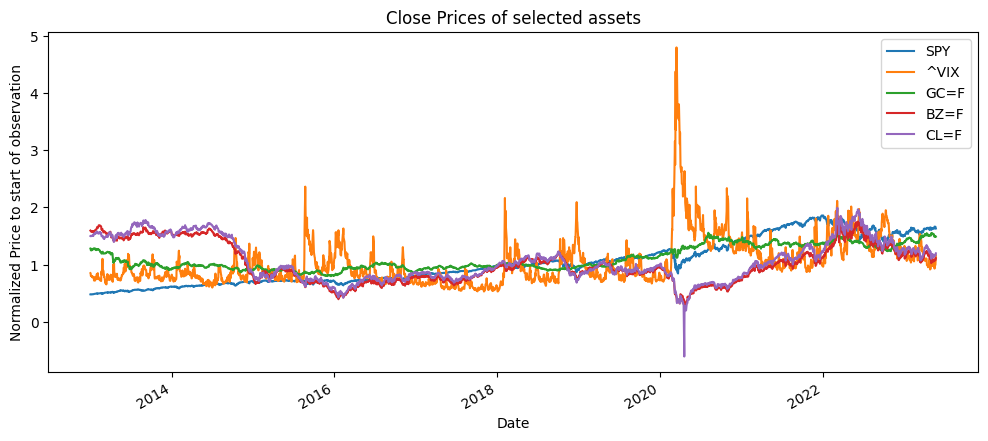

In [7]:
data.plot_price_trends(reference = 0)

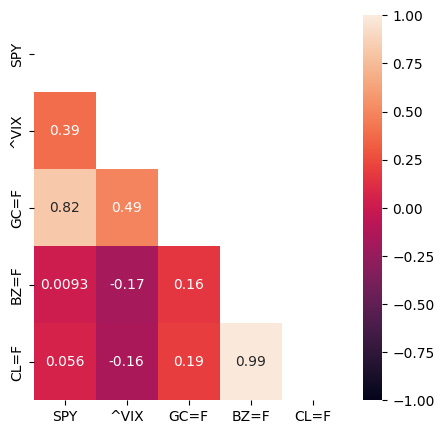

In [8]:
data.plot_corr()

## Generate technical indicators

In [9]:
data.get_technical_indicators()
data.pv['CL=F'].tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_5,SMA_14,ATR_5,ATR_14,ADX_5,ADX_14,RSI_5,RSI_14,MACD,MACD_signal,BBANDS_upp,BBANDS_mid,BBANDS_low
Date,,,,,,,,,,,,,,,,,,,,
2023-05-18 00:00:00-04:00,72.750000,72.870003,71.419998,71.860001,80864,0.0,0.0,71.340001,71.630001,2.334759,2.589797,26.485585,24.932016,49.730616,44.982792,-1.394847,-1.386904,73.229721,71.340001,69.450281
2023-05-19 00:00:00-04:00,71.940002,73.400002,71.029999,71.550003,69949,0.0,0.0,71.642001,71.336429,2.341808,2.574098,23.747167,24.350027,46.789674,44.216580,-1.342506,-1.378025,73.016594,71.642001,70.267408
2023-05-22 00:00:00-04:00,71.699997,72.360001,70.550003,71.989998,263977,0.0,0.0,71.818001,71.360000,2.235446,2.519519,19.563407,24.010455,51.842410,45.632110,-1.251100,-1.352640,73.097088,71.818001,70.538914
2023-05-23 00:00:00-04:00,72.099998,73.790001,71.709999,72.910004,317586,0.0,0.0,72.228001,71.667858,2.204357,2.488125,22.082936,22.859615,61.418052,48.570786,-1.091837,-1.300479,73.315856,72.228001,71.140147
2023-05-24 00:00:00-04:00,73.769997,74.730003,73.129997,74.339996,386611,0.0,0.0,72.530000,72.080715,2.127486,2.440402,27.063144,21.291910,72.169687,52.837864,-0.840542,-1.208492,74.554132,72.530000,70.505869


## Apply machine learning

In [10]:
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM
from keras.regularizers import L1, L1L2, L2
from tensorflow.keras.optimizers import Adam, SGD


from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

import numpy as np
import tensorflow as tf
import random as python_random

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os

def reset_seeds(SEED = 624):
    np.random.seed(SEED) 
    python_random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)

tf.config.experimental.enable_op_determinism()

### Extract features

Target: WTI crude oil price (Close)
Features universe: 
- set 1: Prices of other assets
- set 2: TA indicators of WTI
- set 3: Prices of other assets, TA indicators of WTI
- set 4: Other data

In [11]:
set1 = ["SPY", "^VIX", "GC=F", "BZ=F", "CL=F"]
set2 = ['Close', 'Volume', 'SMA_5', 'SMA_14', 'ATR_5', 'ATR_14', 'ADX_5', 'ADX_14', 'RSI_5',
       'RSI_14', 'MACD', 'MACD_signal', 'BBANDS_upp', 'BBANDS_mid', 'BBANDS_low']
set3 = set1 + set2

In [12]:
target_ticker = "CL=F"
Y1 = np.array(data.lp[target_ticker]).reshape(-1,1)
X1 = np.array(data.lp.drop(target_ticker, axis = 1))
Y2 = np.array(data.pv['CL=F']['Close']).reshape(-1,1)
X2 = np.array(data.pv['CL=F'][set2])


In [13]:
class LSTM_predictor:
    """A class for predicting time series using LSTM (Long Short-Term Memory) models."""
    def __init__(self, X, Y):
        """
        Initializes a new instance of the LSTM_predictor class.

        Args:
            X (ndarray): The input feature matrix.
            Y (ndarray): The target values.
        """
        self.X, self.Y = self.__clean_data__(X, Y)
        self.features_size = X.shape[1]
        self.obs_size = X.shape[0]
        
        
    def __clean_data__(self, X, Y):
        """
        Cleans the input feature matrix and target values by removing rows with NaN values.

        Args:
            X (ndarray): The input feature matrix.
            Y (ndarray): The target values.

        Returns:
            ndarray: The cleaned input feature matrix.
            ndarray: The cleaned target values.
        """
        Z = np.concatenate((X, Y), axis = 1)
        Z = Z[~np.isnan(Z).any(axis=1), :]
        return Z[:, :-1], Z[:, -1]
        
    def prepare_data(self, train_test_split = 0.8, timestep = 3, look_forward = 1, inplace = False, scaled = True):
        """
        Prepares the data for training and testing the LSTM model.

        Args:
            train_test_split (float, optional): The fraction of data to be used for training.
                Defaults to 0.8.
            timestep (int, optional): The number of time steps to consider for each sample.
                Defaults to 3.
            inplace (bool, optional): Indicates whether to store the prepared data in the class
                instance or return it. Defaults to False.
            scaled (bool, optional): Indicates whether to scale the data. Defaults to True.

        Returns:
            tuple or None: If inplace=True, returns None. Otherwise, returns a tuple containing
            the prepared training and testing data as (X_train, Y_train, X_test, Y_test).
        """
        split_idx = int(self.obs_size*0.8)
        train_set = self.X[:split_idx,:], self.Y[:split_idx]
        test_set = self.X[split_idx:,:], self.Y[split_idx:]
        
        # Scale factors
        mean_X = np.mean(train_set[0], axis = 0)
        std_X = np.std(train_set[0], axis = 0)
        self.__scale_X__ = (mean_X, std_X)
        
        mean_Y = np.mean(train_set[1], axis = 0)
        std_Y = np.std(train_set[1], axis = 0)
        self.__scale_Y__ = (mean_Y, std_Y)
        
        
        
        sampled = []
        
        for X, Y in [train_set, test_set]:
            X_sampled, Y_sampled = [], []

            for i in range(len(X)-timestep-look_forward+1):
                X_sampled.append((X[i:i+timestep] - self.__scale_X__[0])/self.__scale_X__[1])
                Y_sampled.append((Y[i+timestep+look_forward-1] - self.__scale_Y__[0])/self.__scale_Y__[1])
            
            sampled.append((np.array(X_sampled),np.array(Y_sampled)))
        
        if inplace:
            self.X_train, self.Y_train = sampled[0]
            self.X_test, self.Y_test = sampled[1]
            
            return None
        else:
            return sampled
        
    def init_model(self, optimizer='adam', loss='mean_squared_error', kernel_regularizer=None, num_lstm_units = 128, num_lstm_units_2 = 64,num_dense_units = 25, learning_rate=0.005):
        """
        Initializes the LSTM model with the specified optimizer and loss function.

        Args:
            optimizer (str, optional): The optimizer to use. Defaults to 'adam'.
            loss (str, optional): The loss function to use. Defaults to 'mean_squared_error'.
        """
        reset_seeds()
        model = Sequential()
        model.add(LSTM(num_lstm_units, return_sequences=True,\
                       input_shape= (self.X_train.shape[1], self.features_size),\
                      kernel_regularizer=kernel_regularizer))
        model.add(LSTM(num_lstm_units_2, return_sequences=False, kernel_regularizer=kernel_regularizer, activation = 'relu'))
        model.add(Dense(num_dense_units))
        model.add(Dense(1))
        
        if optimizer == 'adam':
            opt = Adam(learning_rate=learning_rate)
        elif optimizer == 'SGD':
            opt = SGD(learning_rate=learning_rate)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer}")
        
        model.compile(optimizer = optimizer, loss = loss)
        self.model = model
        
        return None
    
    def fit_model_train(self, batch_size=100, epochs=50, callbacks=None):
        """
        Trains the LSTM model.

        Args:
            batch_size (int, optional): The batch size for training. 
            epochs (int, optional): The number of epochs to train for. 
        """
        self.test_loss_list = []
        self.pred_per_epoch = []
        history_train = self.model.fit(self.X_train, self.Y_train, epochs=epochs, batch_size=batch_size, verbose=1, callbacks = callbacks)
        self.train_loss_list = history_train.history['loss']  # Store loss values in the list 
        
#     def fit_model_test(self, epochs, batch_size, k_folds = 5):
#         """
#         ONLY TO GET THE LOSS CURVE
#         """
#         history_test = self.model.fit(self.X_test, self.Y_test, epochs=epochs, batch_size=batch_size, verbose=1)
#         self.test_loss_list = history_test.history['loss']  # Store loss values in the list --> do it for this as well
       
        
    def predict(self):
        """Makes predictions using the trained LSTM model."""
        self.Y_pred = self.model.predict(self.X_test)
        mse = mean_squared_error(self.Y_test, self.Y_pred)
        mse_list.append(mse)
        
    def plot_prediction(self, epoch = None):
        """Plots the predicted and actual values."""
        if epoch == None:
            Y_pred = self.Y_pred
        else:
            Y_pred = self.pred_per_epoch[epoch - 1]
        actual = np.concatenate((self.Y_train.reshape(-1,1), self.Y_test.reshape(-1,1)))
        actual = actual*self.__scale_Y__[1] + self.__scale_Y__[0]
        prediction = np.concatenate((self.Y_train.reshape(-1,1), Y_pred))
        prediction = prediction*self.__scale_Y__[1] + self.__scale_Y__[0]
        
        f, ax = plt.subplots(figsize=(12,5))
        plt.plot(prediction, label = 'Predicted')
        plt.plot(actual, label = 'Actual')
        
        ax.title.set_text('Close Prices of selected assets')
        ax.set(ylabel = 'Normalized Price to start of observation')
        ax.legend()
        plt.show()
        
    def key_metrics(self,epoch=None):
        Y_pred = self.Y_pred if epoch == None else self.pred_per_epoch[epoch-1]
        mse = mean_squared_error(self.Y_test, Y_pred)
        mae = mean_absolute_error(self.Y_test, Y_pred)
        exp_ratio = explained_variance_score(self.Y_test, Y_pred)
        
        print(f'MSE: {mse}\nMAE: {mae}\nExplained ratio: {exp_ratio}')


    def forward_test(self,num_lstm_units, num_lstm_units_2,num_dense_units,kernel_regularizer=None, optimizer='adam', loss='mean_squared_error', batch_size=100, epochs=5, learning_rate = 0.005):
        model = Sequential()
        model.add(LSTM(num_lstm_units, return_sequences=True,\
                       input_shape= (self.X_train.shape[1], self.features_size),\
                      kernel_regularizer=kernel_regularizer))
        model.add(LSTM(num_lstm_units_2, return_sequences=False, kernel_regularizer=kernel_regularizer))
        model.add(Dense(num_dense_units))
        model.add(Dense(1))
        
        if optimizer == 'adam':
            opt = Adam(learning_rate=learning_rate)
        elif optimizer == 'SGD':
            opt = SGD(learning_rate=learning_rate)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer}")

        model.compile(optimizer = optimizer, loss = loss)
        model = model   

        model.fit(self.X_train, self.Y_train, batch_size=batch_size, epochs=5)

        self.Y_pred = model.predict(self.X_test)
        
        print(self.Y_test.shape)
        print(self.Y_pred.shape)

        mse = mean_squared_error(self.Y_test, self.Y_pred) *-1
        mae = mean_absolute_error(self.Y_test, self.Y_pred)
        exp_ratio = explained_variance_score(self.Y_test, self.Y_pred)

        return mse         
    
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, model_class):
        self.mega_class = model_class
        self.model = model_class.model
        self.X_test = model_class.X_test
        self.Y_test = model_class.Y_test

    def on_epoch_end(self, epoch, logs={}):
        self.Y_pred = self.model.predict(self.X_test)
        mse = mean_squared_error(self.Y_test, self.Y_pred)
        self.mega_class.test_loss_list.append(mse)
        self.mega_class.pred_per_epoch.append(self.Y_pred)

## Model 1: LSTM crude oil price prediction using other assets' price movement

### Model

Epoch 1/50
21/21 [==============================] - 11s 72ms/step - loss: 0.1364
Epoch 2/50
21/21 [==============================] - 1s 47ms/step - loss: 0.0252
Epoch 3/50
21/21 [==============================] - 1s 47ms/step - loss: 0.0200
Epoch 4/50
21/21 [==============================] - 1s 47ms/step - loss: 0.0153
Epoch 5/50
21/21 [==============================] - 1s 48ms/step - loss: 0.0140
Epoch 6/50
21/21 [==============================] - 1s 47ms/step - loss: 0.0138
Epoch 7/50
21/21 [==============================] - 1s 46ms/step - loss: 0.0122
Epoch 8/50
21/21 [==============================] - 1s 47ms/step - loss: 0.0123
Epoch 9/50
21/21 [==============================] - 1s 47ms/step - loss: 0.0122
Epoch 10/50
21/21 [==============================] - 1s 46ms/step - loss: 0.0126
Epoch 11/50
21/21 [==============================] - 1s 46ms/step - loss: 0.0112
Epoch 12/50
21/21 [==============================] - 1s 46ms/step - loss: 0.0116
Epoch 13/50
21/21 [=================

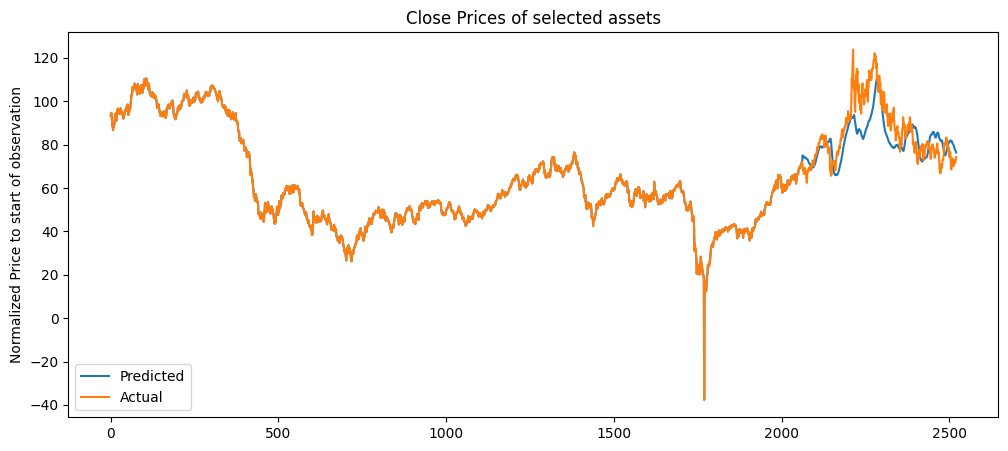

In [14]:
mse_list = []
model1 = LSTM_predictor(X2, Y2)
model1.prepare_data(train_test_split = 0.8, timestep = 30, look_forward = 3, inplace = True)
model1.init_model(optimizer='adam', loss='mean_squared_error')
model1.fit_model_train(epochs=50,batch_size=100,callbacks=[CustomCallback(model1)])
model1.predict()
model1.key_metrics()
model1.plot_prediction()

In [15]:
def loss_curve(model,x=2):
    # Access train loss values
    train_loss_values = model.train_loss_list

    # Access test loss values
    test_loss_values = model.test_loss_list

    min_test_loss = test_loss_values.index(min(test_loss_values))

    plt.figure(figsize=(10,6))

    # Create a plot of train and test loss
    plt.plot(train_loss_values, label='Train Loss')
    plt.plot(test_loss_values, label='Test Loss')
    plt.axvline(x=min_test_loss,ls='--',c='r', label = 'Min Test Loss')

    # Set plot labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss')

    plt.ylim(0,x)
    plt.xticks(np.arange(1,51,2))

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()
    
    model.key_metrics(epoch = min_test_loss)
    model.plot_prediction(epoch = min_test_loss)

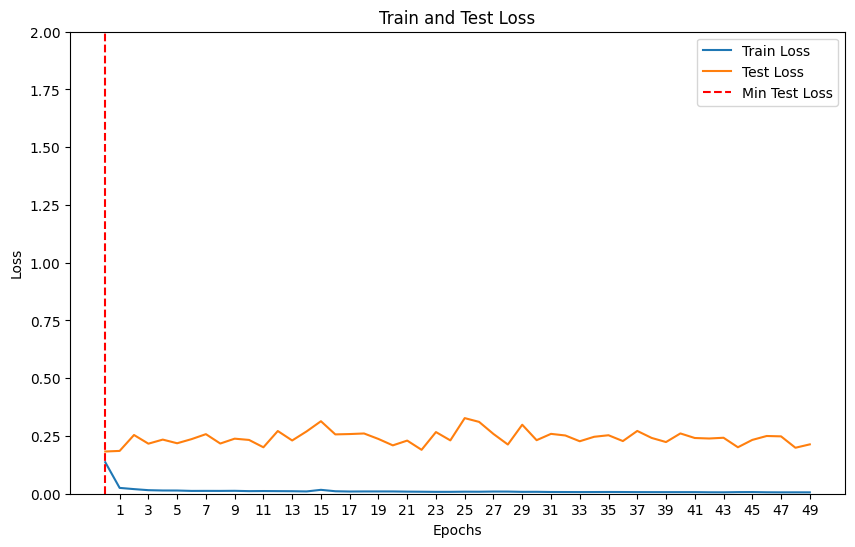

MSE: 0.21365600735759946
MAE: 0.3684450209468207
Explained ratio: 0.5502666513792902


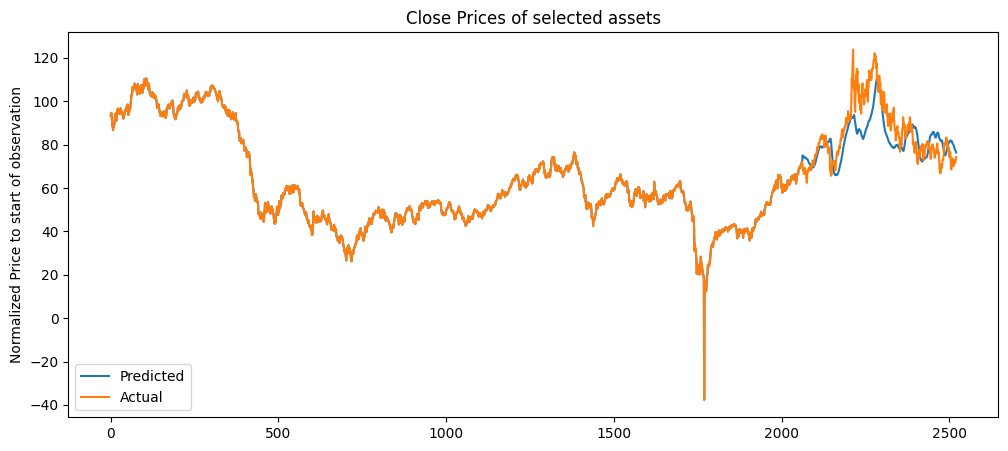

In [16]:
loss_curve(model1)

### Generate Training Data

In [17]:
import torch

In [18]:
# generate initial training dataset for optimization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double

num_lstm_units_bound = [32,512] #random_num
num_lstm_units_bound_2 = [32,512] #random_num_2
num_dense_units_bound = [16,256] #random_num_3
batch_size_bound = [100, 200] #random_num_4
learning_rate_bound = [0.005,0.01] #random_num_5
#optimizer_bound = ['adam', 'SGD'] #random_num_6


cuda


In [19]:
import random

n = 5  # Number of random integers to generate

random_nums = []
for _ in range(n):
    random_num = random.randint(num_lstm_units_bound[0], num_lstm_units_bound[1])
    random_nums.append(random_num)
    
random_nums_2 = []
for _ in range(n):
    random_num_2 = random.randint(num_lstm_units_bound_2[0], num_lstm_units_bound_2[1])
    random_nums_2.append(random_num_2)

random_nums_3 = []
for _ in range(n):
    random_num_3 = random.randint(num_dense_units_bound[0], num_dense_units_bound[1])
    random_nums_3.append(random_num_3)
    
random_nums_4 = []
for _ in range(n):
    random_num_4 = random.randint(batch_size_bound[0], batch_size_bound[1])
    random_nums_4.append(random_num_4)
    
random_nums_5 = []
for _ in range(n):
    random_num_5 = random.uniform(learning_rate_bound[0], learning_rate_bound[1])
    random_nums_5.append(random_num_5)
    
# random_nums_6 = []
# for _ in range(n):
#     random_num_6 = random.choice(optimizer_bound)
#     random_nums_6.append(random_num_6)
    
random_nums_tensor = torch.tensor(random_nums, dtype=torch.float64, device = device).reshape(n, 1)
random_nums_2_tensor = torch.tensor(random_nums_2, dtype=torch.float64, device = device).reshape(n, 1)
random_nums_3_tensor = torch.tensor(random_nums_3, dtype=torch.float64, device = device).reshape(n, 1)
random_nums_4_tensor = torch.tensor(random_nums_4, dtype=torch.float64, device = device).reshape(n, 1)
random_nums_5_tensor = torch.tensor(random_nums_5, dtype=torch.float64, device = device).reshape(n, 1)
# label_map = {string: i for i, string in enumerate(random_nums_6)}  # Create a mapping of strings to integer labels
# integer_labels = [label_map[string] for string in random_nums_6]  # Convert strings to integer labels
# random_nums_6_tensor = torch.tensor(integer_labels, dtype=torch.long).reshape(n, 1)


train_x = torch.cat((random_nums_tensor, random_nums_2_tensor,random_nums_3_tensor,random_nums_4_tensor,random_nums_5_tensor), 1)

In [20]:

# obtain the exact value of the objective function and add output dimension
train_y = []
for i in range(len(random_nums)):
    train_y.append(model1.forward_test(num_lstm_units = random_nums[i],num_lstm_units_2 = random_nums_2[i], num_dense_units = random_nums_3[i], batch_size = random_nums_4[i], learning_rate = random_nums_5[i]))


Epoch 1/5
13/13 [==============================] - 4s 8ms/step - loss: 0.1578
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0274
Epoch 3/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0198
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0163
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 8ms/step - loss: 0.1935
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0329
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0208
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0172
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 4s 8ms/step - loss: 0.1236
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0259
Epoch 3/5
15/15 [==============================] - 0s 7ms/step

In [21]:
train_y = torch.tensor(train_y, device=device).to(dtype).unsqueeze(-1)  
# get the current best observed value, i.e., utility of the available dataset
best_observed_value = train_y.max().item()

### Initialize and Optimize GP Model

In [22]:
train_x

tensor([[3.2500e+02, 2.9900e+02, 2.4000e+02, 1.6000e+02, 9.5852e-03],
        [4.4000e+02, 3.3400e+02, 2.2100e+02, 1.8500e+02, 6.1596e-03],
        [1.7300e+02, 4.7400e+02, 9.7000e+01, 1.4000e+02, 7.0036e-03],
        [2.0700e+02, 3.6700e+02, 1.1400e+02, 1.3700e+02, 9.4891e-03],
        [1.9000e+02, 5.7000e+01, 1.7300e+02, 1.9900e+02, 9.5589e-03]],
       device='cuda:0', dtype=torch.float64)

In [24]:
!pip install botorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.3/530.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 20.5 MB/s eta 0:00:00


In [25]:
# initialize GP model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood

def initialize_model(train_x, train_y):
    # create a single-task exact GP model instance
    # use a GP prior with Matern kernel and constant mean function by default
    #train_y = train_y.squeeze(1)
    model = SingleTaskGP(train_X=train_x, train_Y=train_y)
    # mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # noise = torch.randn_like(train_y) * 0.01
    # noisy_train_y = train_y + noise
    # model.likelihood.train_targets = noisy_train_y
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    return mll, model

mll, model = initialize_model(train_x, train_y)
list(model.named_hyperparameters())

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([2.0000], device='cuda:0', dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(0., device='cuda:0', dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(0., device='cuda:0', dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[0., 0., 0., 0., 0.]], device='cuda:0', dtype=torch.float64,
         requires_grad=True))]

In [26]:
# optimize GP hyperparameters
from botorch.fit import fit_gpytorch_mll
# fit hyperparameters (kernel parameters and noise variance) of a GPyTorch model 
fit_gpytorch_mll(mll.cuda())
mll = mll.to(train_x)
model = model.to(train_x)
list(model.named_hyperparameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([0.0043], device='cuda:0', dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(-0.1315, device='cuda:0', dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(-5.0677, device='cuda:0', dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[-1.3740, -1.3740, -1.3740, -1.3740, -1.3740]], device='cuda:0',
         dtype=torch.float64, requires_grad=True))]

### Initialize Acquisition Function

In [27]:
# define acquisition function
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient

# initialize model
train_x_ei = train_x
train_x_qei = train_x
train_x_ucb = train_x
train_x_qkg = train_x
train_y_ei = train_y
train_y_qei = train_y
train_y_ucb = train_y
train_y_qkg = train_y

mll_ei, model_ei = initialize_model(train_x_ei, train_y_ei)
mll_qei, model_qei = initialize_model(train_x_qei, train_y_qei)
mll_ucb, model_ucb = initialize_model(train_x_ucb, train_y_ucb)
mll_qkg, model_qkg = initialize_model(train_x_qkg, train_y_qkg)

# EI = ExpectedImprovement(model=model_ei, best_f=best_observed_value)
# qEI = qExpectedImprovement(model=model_qei, best_f=best_observed_value)
# beta = 0.8
# UCB = UpperConfidenceBound(model=model_ucb, beta=beta)
# num_fantasies = 64
# qKG = qKnowledgeGradient(
#     model=model_qkg,
#     num_fantasies=num_fantasies,
#     X_baseline=train_x,
#     q=1
# )

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [28]:
# optimize and get new observation
from botorch.optim import optimize_acqf

# get search bounds
bounds = torch.tensor([[num_lstm_units_bound[0],num_lstm_units_bound_2[0], num_dense_units_bound[0],batch_size_bound[0],learning_rate_bound[0]], [num_lstm_units_bound[1],num_lstm_units_bound_2[1], num_dense_units_bound[1],batch_size_bound[1],learning_rate_bound[1]]], device=device, dtype=dtype)
# parallel candidate locations generated in each iteration
BATCH_SIZE = 1
# number of starting points for multistart optimization
NUM_RESTARTS = 10
# number of samples for initialization
RAW_SAMPLES = 1024

def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, value = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    )
    # observe new values 
    new_x = candidates.detach()
    # sample output value
    new_y = model1.forward_test(num_lstm_units = int(new_x.squeeze()[0].item()), num_lstm_units_2 = int(new_x.squeeze()[1].item()), num_dense_units = int(new_x.squeeze()[2].item()),batch_size = int(new_x.squeeze()[3].item()), learning_rate= new_x.squeeze()[4].item())

    # add output dimension
    new_y = torch.tensor([new_y], device=device).to(dtype).unsqueeze(-1)  
    # print("new fn value:", new_y)
    
    return new_x, new_y


In [29]:
def update_random_observations(best_random):
    """Simulates a random policy by drawing a new random points, 
        observing their values, and updating the current best candidate to the running list.
    """
    num_lstm_units_bound = [32,512] #random_num
    num_lstm_units_bound_2 = [32,512] #random_num_2
    num_dense_units_bound = [16,256] #random_num_3
    batch_size_bound = [100, 200] #random_num_4
    learning_rate_bound = [0.005,0.01] #random_num_5
    #optimizer_bound = ['adam', 'SGD'] #random_num_6

    n = 1  # Number of random integers to generate

    random_nums = []
    for _ in range(n):
        random_num = random.randint(num_lstm_units_bound[0], num_lstm_units_bound[1])
        random_nums.append(random_num)

    random_nums_2 = []
    for _ in range(n):
        random_num_2 = random.randint(num_lstm_units_bound_2[0], num_lstm_units_bound_2[1])
        random_nums_2.append(random_num_2)

    random_nums_3 = []
    for _ in range(n):
        random_num_3 = random.randint(num_dense_units_bound[0], num_dense_units_bound[1])
        random_nums_3.append(random_num_3)

    random_nums_4 = []
    for _ in range(n):
        random_num_4 = random.randint(batch_size_bound[0], batch_size_bound[1])
        random_nums_4.append(random_num_4)

    random_nums_5 = []
    for _ in range(n):
        random_num_5 = random.uniform(learning_rate_bound[0], learning_rate_bound[1])
        random_nums_5.append(random_num_5)

    # random_nums_6 = []
    # for _ in range(n):
    #     random_num_6 = random.choice(optimizer_bound)
    #     random_nums_6.append(random_num_6)

    random_nums_tensor = torch.tensor(random_nums, dtype=torch.float64, device = device).reshape(n, 1)
    random_nums_2_tensor = torch.tensor(random_nums_2, dtype=torch.float64, device = device).reshape(n, 1)
    random_nums_3_tensor = torch.tensor(random_nums_3, dtype=torch.float64, device = device).reshape(n, 1)
    random_nums_4_tensor = torch.tensor(random_nums_4, dtype=torch.float64, device = device).reshape(n, 1)
    random_nums_5_tensor = torch.tensor(random_nums_5, dtype=torch.float64, device = device).reshape(n, 1)

    new_x = torch.cat((random_nums_tensor, random_nums_2_tensor,random_nums_3_tensor,random_nums_4_tensor,random_nums_5_tensor), 1)

    new_y = model1.forward_test(num_lstm_units = int(new_x[0,0].item()),num_lstm_units_2 = int(new_x[0,1].item()), num_dense_units = int(new_x[0,2].item()),batch_size = int(new_x[0,3].item()),learning_rate = new_x[0,4].item())

    best_random.append(max(best_random[-1], new_y))       
    return best_random

In [30]:
# single trial
import time
N_ROUND = 20
verbose = True
beta = 0.8

best_random, best_observed_ei, best_observed_qei, best_observed_ucb, best_observed_qkg  = [], [], [], [], []
    
best_random.append(best_observed_value)
best_observed_ei.append(best_observed_value)
best_observed_qei.append(best_observed_value)
best_observed_ucb.append(best_observed_value)
best_observed_qkg.append(best_observed_value)

# run N_ROUND rounds of BayesOpt after the initial random batch
for iteration in range(1, N_ROUND + 1):    
    t0 = time.monotonic()
    # fit the models
    fit_gpytorch_mll(mll_ei)
    fit_gpytorch_mll(mll_qei)
    fit_gpytorch_mll(mll_ucb)
    fit_gpytorch_mll(mll_qkg)

    # for best_f, we use the best observed exact values
    EI = ExpectedImprovement(model=model_ei, best_f=train_y_ei.max())
    qEI = qExpectedImprovement(model=model_qei, 
                               best_f=train_y_ei.max(),
                               num_samples=1024
                               )
    UCB = UpperConfidenceBound(model=model_ucb, beta=beta)
    qKG = qKnowledgeGradient(
        model=model_qkg,
        num_fantasies=64,
        objective=None,
        X_baseline=train_x_qkg,
    )
    
    # optimize and get new observation
    new_x_ei, new_y_ei = optimize_acqf_and_get_observation(EI)
    new_x_qei, new_y_qei = optimize_acqf_and_get_observation(qEI)
    new_x_ucb, new_y_ucb = optimize_acqf_and_get_observation(UCB)
    new_x_qkg, new_y_qkg = optimize_acqf_and_get_observation(qKG)
            
    # update training points
    train_x_ei = torch.cat([train_x_ei, new_x_ei], dim=0)
    train_x_qei = torch.cat([train_x_qei, new_x_qei], dim=0)
    train_x_ucb = torch.cat([train_x_ucb, new_x_ucb], dim=0)
    train_x_qkg = torch.cat([train_x_qkg, new_x_qkg], dim=0)
    train_y_ei = torch.cat([train_y_ei, new_y_ei], dim=0)
    train_y_qei = torch.cat([train_y_qei, new_y_qei], dim=0)
    train_y_ucb = torch.cat([train_y_ucb, new_y_ucb], dim=0)
    train_y_qkg = torch.cat([train_y_qkg, new_y_qkg], dim=0)

    # update progress
    best_random = update_random_observations(best_random)
    best_value_ei = max(best_observed_ei[-1], new_y_ei.item())  
    best_value_qei = max(best_observed_qei[-1], new_y_qei.item())  
    best_value_ucb = max(best_observed_ucb[-1], new_y_ucb.item())  
    best_value_qkg = max(best_observed_qkg[-1], new_y_qkg.item())  

    best_observed_ei.append(best_value_ei)
    best_observed_qei.append(best_value_qei)
    best_observed_ucb.append(best_value_ucb)
    best_observed_qkg.append(best_value_qkg)

    # reinitialize the models so they are ready for fitting on next iteration
    mll_ei, model_ei = initialize_model(
        train_x_ei, 
        train_y_ei
    )
    mll_qei, model_qei = initialize_model(
        train_x_qei, 
        train_y_qei
    )
    mll_ucb, model_ucb = initialize_model(
        train_x_ucb, 
        train_y_ucb
    )
    mll_qkg, model_qkg = initialize_model(
        train_x_qkg, 
        train_y_qkg
    )

    t1 = time.monotonic()

Epoch 1/5
21/21 [==============================] - 4s 8ms/step - loss: 0.0959
Epoch 2/5
21/21 [==============================] - 0s 8ms/step - loss: 0.0262
Epoch 3/5
21/21 [==============================] - 0s 8ms/step - loss: 0.0188
Epoch 4/5
21/21 [==============================] - 0s 8ms/step - loss: 0.0158
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.3602
Epoch 2/5
12/12 [==============================] - 0s 10ms/step - loss: 0.0475
Epoch 3/5
12/12 [==============================] - 0s 10ms/step - loss: 0.0289
Epoch 4/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0209
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 7ms/step - loss: 0.2455
Epoch 2/5
14/14 [==============================] - 0s 6ms/step - loss: 0.0475
Epoch 3/5
14/14 [==============================] - 0s 6ms/s

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 10ms/step - loss: 0.2496
Epoch 2/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0483
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0235
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0198
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 7ms/step - loss: 0.1516
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0199
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0168
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.1617
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0318
Epoch 3/5
12/12 [==============================] - 0s 8ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
19/19 [==============================] - 4s 8ms/step - loss: 0.0993
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0213
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0186
Epoch 4/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0162
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 4s 7ms/step - loss: 0.1318
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0291
Epoch 3/5
15/15 [==============================] - 0s 6ms/step - loss: 0.0213
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0162
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 5s 9ms/step - loss: 0.1346
Epoch 2/5
18/18 [==============================] - 0s 9ms/step - loss: 0.0259
Epoch 3/5
18/18 [==============================] - 0s 8ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
12/12 [==============================] - 4s 7ms/step - loss: 0.2114
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0369
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0231
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0192
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
20/20 [==============================] - 5s 9ms/step - loss: 0.2625
Epoch 2/5
20/20 [==============================] - 0s 8ms/step - loss: 0.0298
Epoch 3/5
20/20 [==============================] - 0s 8ms/step - loss: 0.0194
Epoch 4/5
20/20 [==============================] - 0s 8ms/step - loss: 0.0156
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 8ms/step - loss: 0.1973
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0295
Epoch 3/5
13/13 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
13/13 [==============================] - 4s 8ms/step - loss: 0.1637
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0315
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0233
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0173
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 4s 9ms/step - loss: 0.2361
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0305
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0179
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
19/19 [==============================] - 4s 7ms/step - loss: 0.1551
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0308
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0218
Epoch 4/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0165
Epoch 5/5
15/15 [==============================] - 2s 3ms/step
(459,)
(459, 1)
Epoch 1/5
19/19 [==============================] - 4s 7ms/step - loss: 0.1413
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0266
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0182
Epoch 4/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0159
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 10ms/step - loss: 0.1940
Epoch 2/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0371
Epoch 3/5
11/11 [==============================] - 0s 9ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 9ms/step - loss: 0.2064
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0370
Epoch 3/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0225
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0173
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 5s 9ms/step - loss: 0.1905
Epoch 2/5
18/18 [==============================] - 0s 9ms/step - loss: 0.0254
Epoch 3/5
18/18 [==============================] - 0s 8ms/step - loss: 0.0196
Epoch 4/5
18/18 [==============================] - 0s 8ms/step - loss: 0.0155
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
20/20 [==============================] - 4s 7ms/step - loss: 0.1197
Epoch 2/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0245
Epoch 3/5
20/20 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
17/17 [==============================] - 4s 7ms/step - loss: 0.1580
Epoch 2/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0259
Epoch 3/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0191
Epoch 4/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 9ms/step - loss: 0.2115
Epoch 2/5
14/14 [==============================] - 0s 9ms/step - loss: 0.0325
Epoch 3/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0220
Epoch 4/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0189
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 4s 7ms/step - loss: 0.2051
Epoch 2/5
15/15 [==============================] - 0s 6ms/step - loss: 0.0334
Epoch 3/5
15/15 [==============================] - 0s 6ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
17/17 [==============================] - 4s 7ms/step - loss: 0.1268
Epoch 2/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0273
Epoch 3/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0204
Epoch 4/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0155
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 5s 8ms/step - loss: 0.1914
Epoch 2/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0337
Epoch 3/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0221
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0181
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
17/17 [==============================] - 4s 8ms/step - loss: 0.3002
Epoch 2/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0331
Epoch 3/5
17/17 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
15/15 [==============================] - 4s 8ms/step - loss: 0.2407
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0294
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0183
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 8ms/step - loss: 0.2175
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0362
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0274
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0194
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 4s 9ms/step - loss: 0.3364
Epoch 2/5
18/18 [==============================] - 0s 8ms/step - loss: 0.0302
Epoch 3/5
18/18 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
21/21 [==============================] - 4s 7ms/step - loss: 0.1242
Epoch 2/5
21/21 [==============================] - 0s 7ms/step - loss: 0.0246
Epoch 3/5
21/21 [==============================] - 0s 7ms/step - loss: 0.0177
Epoch 4/5
21/21 [==============================] - 0s 6ms/step - loss: 0.0147
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 5s 8ms/step - loss: 0.1729
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0291
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0199
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0168
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.2904
Epoch 2/5
12/12 [==============================] - 0s 10ms/step - loss: 0.0435
Epoch 3/5
12/12 [==============================] - 0s 9ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
12/12 [==============================] - 4s 8ms/step - loss: 0.2407
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0389
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0220
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0176
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 8ms/step - loss: 0.1755
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0338
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0183
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0156
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
14/14 [==============================] - 4s 7ms/step - loss: 0.1797
Epoch 2/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0373
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0212
Epoch 4/5
14/14 [==============================] - 0s 6ms/step - loss: 0.0181
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 5s 7ms/step - loss: 0.1003
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0209
Epoch 3/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0172
Epoch 4/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 9ms/step - loss: 0.1575
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0278
Epoch 3/5
14/14 [==============================] - 0s 8ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
20/20 [==============================] - 4s 9ms/step - loss: 0.2023
Epoch 2/5
20/20 [==============================] - 0s 8ms/step - loss: 0.0232
Epoch 3/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0206
Epoch 4/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0159
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
19/19 [==============================] - 5s 8ms/step - loss: 0.1510
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0207
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0182
Epoch 4/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
12/12 [==============================] - 4s 7ms/step - loss: 0.2033
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0387
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0255
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0196
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 8ms/step - loss: 0.1803
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0328
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0232
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0175
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
21/21 [==============================] - 4s 7ms/step - loss: 0.1309
Epoch 2/5
21/21 [==============================] - 0s 7ms/step - loss: 0.0292
Epoch 3/5
21/21 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
15/15 [==============================] - 5s 8ms/step - loss: 0.1045
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0214
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0189
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0180
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 9ms/step - loss: 0.1751
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0305
Epoch 3/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0207
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0165
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
12/12 [==============================] - 4s 8ms/step - loss: 0.2328
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0438
Epoch 3/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0243
Epoch 4/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0199
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 5s 9ms/step - loss: 0.2084
Epoch 2/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0366
Epoch 3/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0202
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0165
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
20/20 [==============================] - 4s 7ms/step - loss: 0.1405
Epoch 2/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0266
Epoch 3/5
20/20 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
14/14 [==============================] - 4s 8ms/step - loss: 0.1374
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0259
Epoch 3/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0223
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0161
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 7ms/step - loss: 0.1680
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0315
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0230
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0187
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
21/21 [==============================] - 4s 7ms/step - loss: 0.1713
Epoch 2/5
21/21 [==============================] - 0s 7ms/step - loss: 0.0292
Epoch 3/5
21/21 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 5s 11ms/step - loss: 0.2576
Epoch 2/5
11/11 [==============================] - 0s 11ms/step - loss: 0.0377
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0234
Epoch 4/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0187
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 4s 7ms/step - loss: 0.1787
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0331
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0211
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0179
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
18/18 [==============================] - 4s 7ms/step - loss: 0.1504
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0286
Epoch 3/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0184
Epoch 4/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 5s 7ms/step - loss: 0.1449
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0254
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0176
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0152
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
19/19 [==============================] - 4s 8ms/step - loss: 0.1650
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0259
Epoch 3/5
19/19 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 8ms/step - loss: 0.2379
Epoch 2/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0342
Epoch 3/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0217
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0159
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 4s 9ms/step - loss: 0.1288
Epoch 2/5
18/18 [==============================] - 0s 8ms/step - loss: 0.0238
Epoch 3/5
18/18 [==============================] - 0s 8ms/step - loss: 0.0185
Epoch 4/5
18/18 [==============================] - 0s 8ms/step - loss: 0.0158
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 5s 8ms/step - loss: 0.2785
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0493
Epoch 3/5
12/12 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
14/14 [==============================] - 5s 7ms/step - loss: 0.1907
Epoch 2/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0368
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0226
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0196
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 7ms/step - loss: 0.1927
Epoch 2/5
14/14 [==============================] - 0s 6ms/step - loss: 0.0477
Epoch 3/5
14/14 [==============================] - 0s 6ms/step - loss: 0.0265
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0210
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
19/19 [==============================] - 4s 8ms/step - loss: 0.1062
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0218
Epoch 3/5
19/19 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 9ms/step - loss: 0.2420
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0407
Epoch 3/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0264
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0194
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 8ms/step - loss: 0.1535
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0202
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0171
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 5s 7ms/step - loss: 0.1595
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0326
Epoch 3/5
13/13 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
13/13 [==============================] - 5s 10ms/step - loss: 0.2800
Epoch 2/5
13/13 [==============================] - 0s 9ms/step - loss: 0.0382
Epoch 3/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0236
Epoch 4/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0194
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 8ms/step - loss: 0.1695
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0263
Epoch 3/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0194
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0161
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 9ms/step - loss: 0.2333
Epoch 2/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0429
Epoch 3/5
11/11 [==============================] - 0s 8ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
15/15 [==============================] - 4s 9ms/step - loss: 0.1307
Epoch 2/5
15/15 [==============================] - 0s 9ms/step - loss: 0.0235
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0167
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0151
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.1556
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0286
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0254
Epoch 4/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0163
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
19/19 [==============================] - 5s 7ms/step - loss: 0.1399
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0265
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0171
Epoch 4/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0154
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
21/21 [==============================] - 4s 6ms/step - loss: 0.1628
Epoch 2/5
21/21 [==============================] - 0s 6ms/step - loss: 0.0315
Epoch 3/5
21/21 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 4/5
21/21 [==============================] - 0s 6ms/step - loss: 0.0172
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 4s 7ms/step - loss: 0.1779
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0326
Epoch 3/5
15/15 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


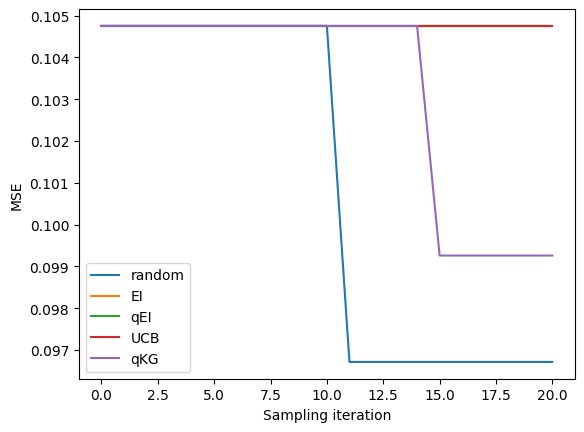

In [31]:
iters = np.arange(N_ROUND + 1) * BATCH_SIZE
plt.plot(iters, np.array(best_random)*-1, label='random')
plt.plot(iters, np.array(best_observed_ei)*-1, label='EI')
plt.plot(iters, np.array(best_observed_qei)*-1, label='qEI')
plt.plot(iters, np.array(best_observed_ucb)*-1, label='UCB')
plt.plot(iters, np.array(best_observed_qkg)*-1, label='qKG')
plt.legend()
plt.xlabel("Sampling iteration")
plt.ylabel("MSE")
plt.show()

Epoch 1/50
36/36 [==============================] - 8s 69ms/step - loss: 0.1166
Epoch 2/50
36/36 [==============================] - 2s 52ms/step - loss: 0.0224
Epoch 3/50
36/36 [==============================] - 2s 52ms/step - loss: 0.0189
Epoch 4/50
36/36 [==============================] - 2s 54ms/step - loss: 0.0202
Epoch 5/50
36/36 [==============================] - 2s 52ms/step - loss: 0.0189
Epoch 6/50
36/36 [==============================] - 2s 52ms/step - loss: 0.0173
Epoch 7/50
36/36 [==============================] - 2s 50ms/step - loss: 0.0175
Epoch 8/50
36/36 [==============================] - 2s 52ms/step - loss: 0.0175
Epoch 9/50
36/36 [==============================] - 2s 51ms/step - loss: 0.0154
Epoch 10/50
36/36 [==============================] - 2s 53ms/step - loss: 0.0160
Epoch 11/50
36/36 [==============================] - 2s 54ms/step - loss: 0.0166
Epoch 12/50
36/36 [==============================] - 2s 51ms/step - loss: 0.0144
Epoch 13/50
36/36 [==================

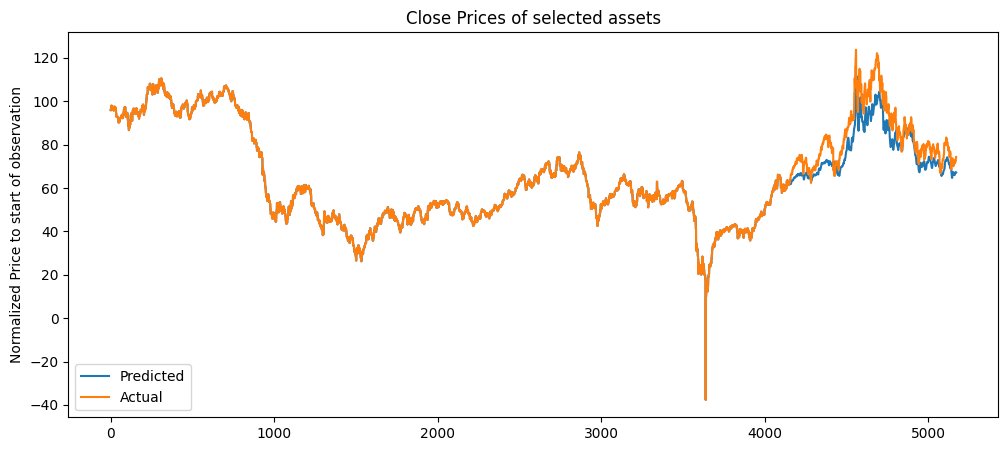

In [32]:
# qKG
mse_list = []
x_list = [[int(x) for x in row.tolist()] for row in train_x_qkg]

qkg_data = {'x':x_list[:21],'mse':best_observed_qkg}
qkg_final = pd.DataFrame(qkg_data)

qkg_test = qkg_final.loc[qkg_final['mse']== (qkg_final['mse'].max()),'x'].values[0]

model1_optimized_qkg = LSTM_predictor(X1, Y1)
model1_optimized_qkg.prepare_data(train_test_split = 0.8, timestep = 30, look_forward = 3, inplace = True)
model1_optimized_qkg.init_model(optimizer='adam', loss='mean_squared_error', num_lstm_units = qkg_test[0] ,num_lstm_units_2 = qkg_test[1], num_dense_units = qkg_test[2], learning_rate = qkg_test[4])
model1_optimized_qkg.fit_model_train(epochs=50,batch_size=qkg_test[3],callbacks=[CustomCallback(model1_optimized_qkg)])
model1_optimized_qkg.predict()
model1_optimized_qkg.key_metrics()
model1_optimized_qkg.plot_prediction()

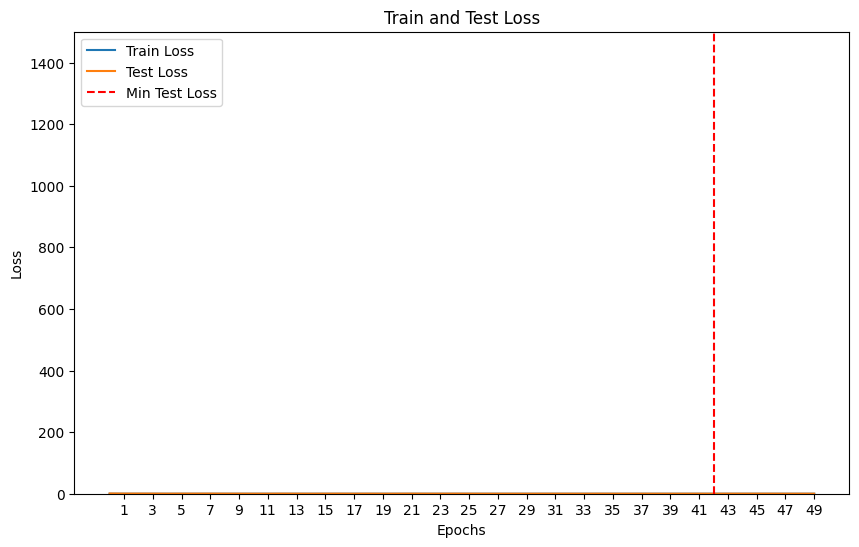

MSE: 0.14888300250466074
MAE: 0.3394238492006976
Explained ratio: 0.9035804285090853


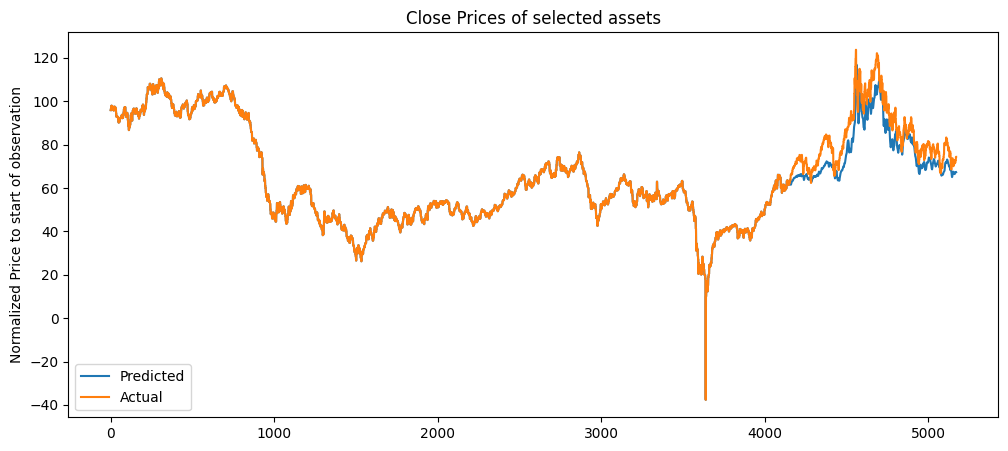

In [33]:
loss_curve(model1_optimized_qkg,1500)

Epoch 1/50
26/26 [==============================] - 6s 77ms/step - loss: 0.1557
Epoch 2/50
26/26 [==============================] - 1s 58ms/step - loss: 0.0280
Epoch 3/50
26/26 [==============================] - 1s 56ms/step - loss: 0.0197
Epoch 4/50
26/26 [==============================] - 2s 58ms/step - loss: 0.0184
Epoch 5/50
26/26 [==============================] - 1s 57ms/step - loss: 0.0181
Epoch 6/50
26/26 [==============================] - 1s 58ms/step - loss: 0.0158
Epoch 7/50
26/26 [==============================] - 1s 56ms/step - loss: 0.0149
Epoch 8/50
26/26 [==============================] - 1s 56ms/step - loss: 0.0145
Epoch 9/50
26/26 [==============================] - 1s 57ms/step - loss: 0.0148
Epoch 10/50
26/26 [==============================] - 1s 56ms/step - loss: 0.0178
Epoch 11/50
26/26 [==============================] - 1s 57ms/step - loss: 0.0168
Epoch 12/50
26/26 [==============================] - 1s 57ms/step - loss: 0.0144
Epoch 13/50
26/26 [==================

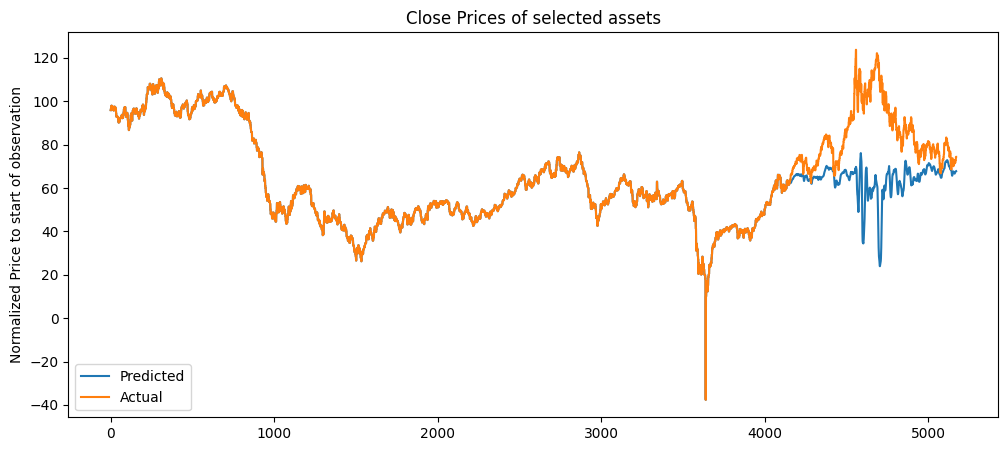

In [34]:
# UCB
mse_list = []
x_list = [[int(x) for x in row.tolist()] for row in train_x_ucb]

ucb_data = {'x':x_list[:21],'mse':best_observed_ucb}
ucb_final = pd.DataFrame(ucb_data)

ucb_test = ucb_final.loc[ucb_final['mse']== (ucb_final['mse'].max()),'x'].values[0]

model1_optimized_ucb = LSTM_predictor(X1, Y1)
model1_optimized_ucb.prepare_data(train_test_split = 0.8, timestep = 30, look_forward = 3, inplace = True)
model1_optimized_ucb.init_model(optimizer='adam', loss='mean_squared_error', num_lstm_units = ucb_test[0] ,num_lstm_units_2 = ucb_test[1], num_dense_units = ucb_test[2], learning_rate = ucb_test[4])
model1_optimized_ucb.fit_model_train(epochs=50,batch_size=ucb_test[3],callbacks=[CustomCallback(model1_optimized_ucb)])
model1_optimized_ucb.predict()
model1_optimized_ucb.key_metrics()
model1_optimized_ucb.plot_prediction()

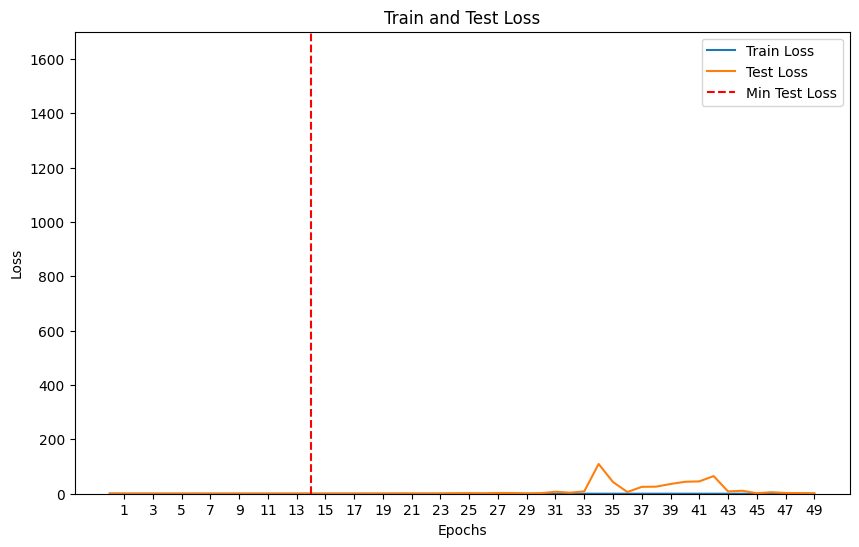

MSE: 0.3829831526929121
MAE: 0.5200487671151881
Explained ratio: 0.7139608084584298


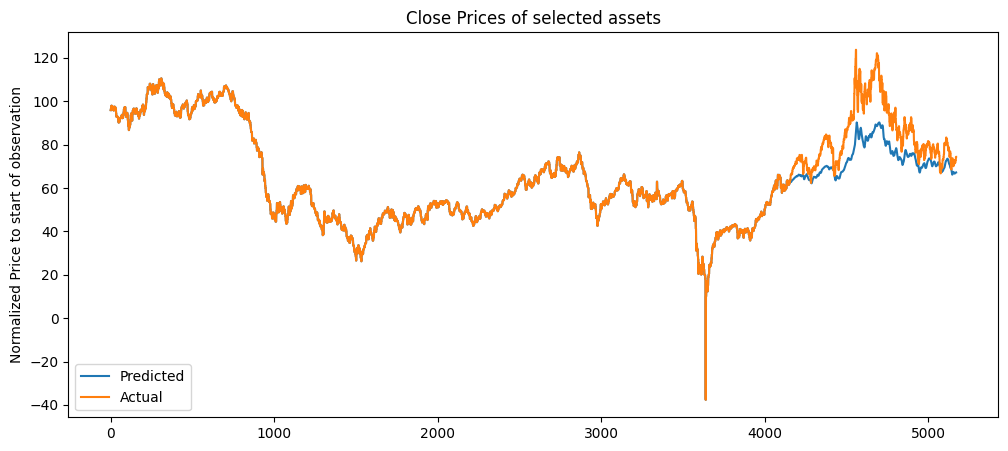

In [35]:
loss_curve(model1_optimized_ucb,1700)

Epoch 1/50
26/26 [==============================] - 6s 75ms/step - loss: 0.1557
Epoch 2/50
26/26 [==============================] - 1s 57ms/step - loss: 0.0280
Epoch 3/50
26/26 [==============================] - 1s 54ms/step - loss: 0.0197
Epoch 4/50
26/26 [==============================] - 1s 55ms/step - loss: 0.0184
Epoch 5/50
26/26 [==============================] - 1s 54ms/step - loss: 0.0181
Epoch 6/50
26/26 [==============================] - 1s 54ms/step - loss: 0.0158
Epoch 7/50
26/26 [==============================] - 1s 55ms/step - loss: 0.0149
Epoch 8/50
26/26 [==============================] - 1s 53ms/step - loss: 0.0145
Epoch 9/50
26/26 [==============================] - 1s 55ms/step - loss: 0.0148
Epoch 10/50
26/26 [==============================] - 1s 57ms/step - loss: 0.0178
Epoch 11/50
26/26 [==============================] - 2s 58ms/step - loss: 0.0168
Epoch 12/50
26/26 [==============================] - 1s 54ms/step - loss: 0.0144
Epoch 13/50
26/26 [==================

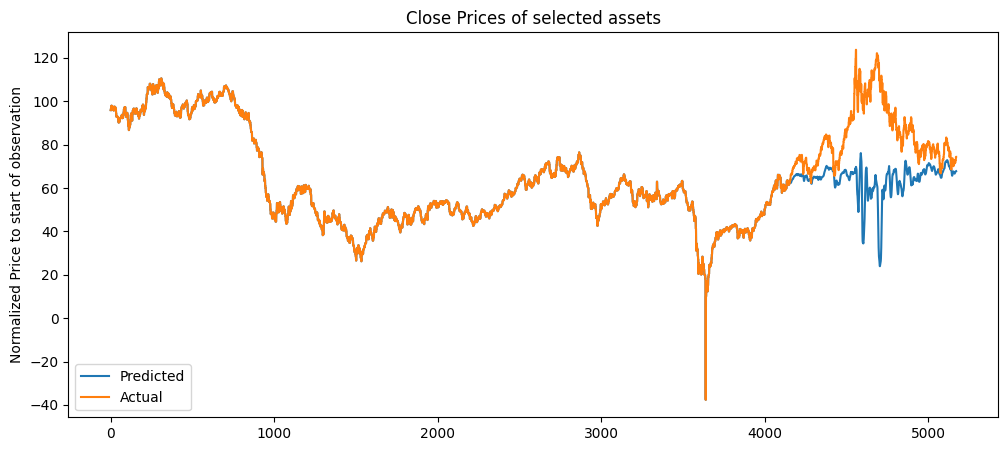

In [36]:
# qEI
mse_list = []
x_list = [[int(x) for x in row.tolist()] for row in train_x_qei]

qei_data = {'x':x_list[:21],'mse':best_observed_qei}
qei_final = pd.DataFrame(qei_data)

qei_test = qei_final.loc[qei_final['mse']== (qei_final['mse'].max()),'x'].values[0]

model1_optimized_qei = LSTM_predictor(X1, Y1)
model1_optimized_qei.prepare_data(train_test_split = 0.8, timestep = 30, look_forward = 3, inplace = True)
model1_optimized_qei.init_model(optimizer='adam', loss='mean_squared_error', num_lstm_units = qei_test[0] ,num_lstm_units_2 = qei_test[1], num_dense_units = qei_test[2], learning_rate = qei_test[4])
model1_optimized_qei.fit_model_train(epochs=50,batch_size=qei_test[3],callbacks=[CustomCallback(model1_optimized_qei)])
model1_optimized_qei.predict()
model1_optimized_qei.key_metrics()
model1_optimized_qei.plot_prediction()

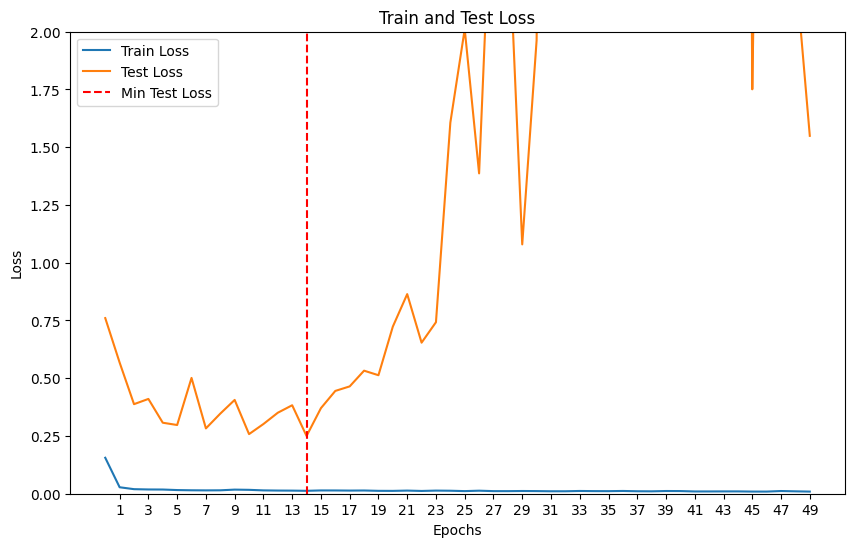

MSE: 0.3829831526929121
MAE: 0.5200487671151881
Explained ratio: 0.7139608084584298


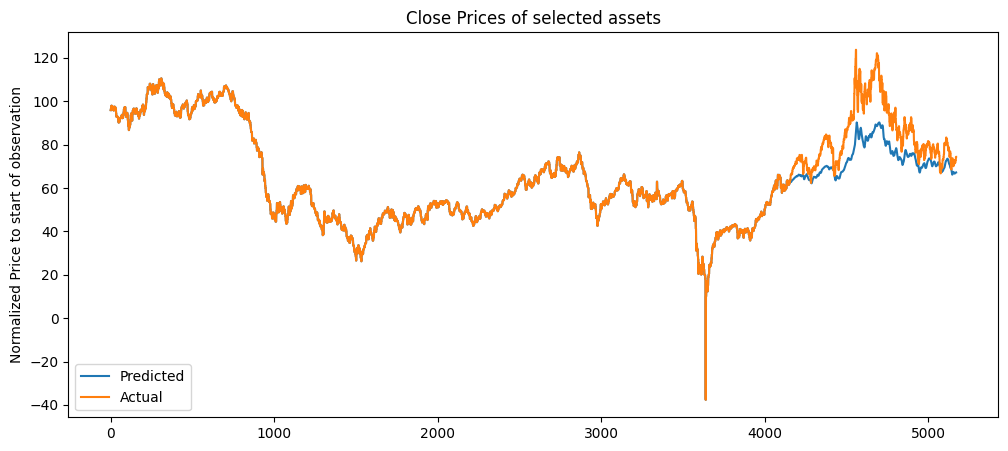

In [37]:
loss_curve(model1_optimized_qei)

Epoch 1/50
26/26 [==============================] - 6s 75ms/step - loss: 0.1557
Epoch 2/50
26/26 [==============================] - 1s 54ms/step - loss: 0.0280
Epoch 3/50
26/26 [==============================] - 1s 54ms/step - loss: 0.0197
Epoch 4/50
26/26 [==============================] - 1s 54ms/step - loss: 0.0184
Epoch 5/50
26/26 [==============================] - 1s 54ms/step - loss: 0.0181
Epoch 6/50
26/26 [==============================] - 1s 54ms/step - loss: 0.0158
Epoch 7/50
26/26 [==============================] - 2s 83ms/step - loss: 0.0149
Epoch 8/50
26/26 [==============================] - 1s 56ms/step - loss: 0.0145
Epoch 9/50
26/26 [==============================] - 1s 56ms/step - loss: 0.0148
Epoch 10/50
26/26 [==============================] - 1s 53ms/step - loss: 0.0178
Epoch 11/50
26/26 [==============================] - 1s 55ms/step - loss: 0.0168
Epoch 12/50
26/26 [==============================] - 1s 55ms/step - loss: 0.0144
Epoch 13/50
26/26 [==================

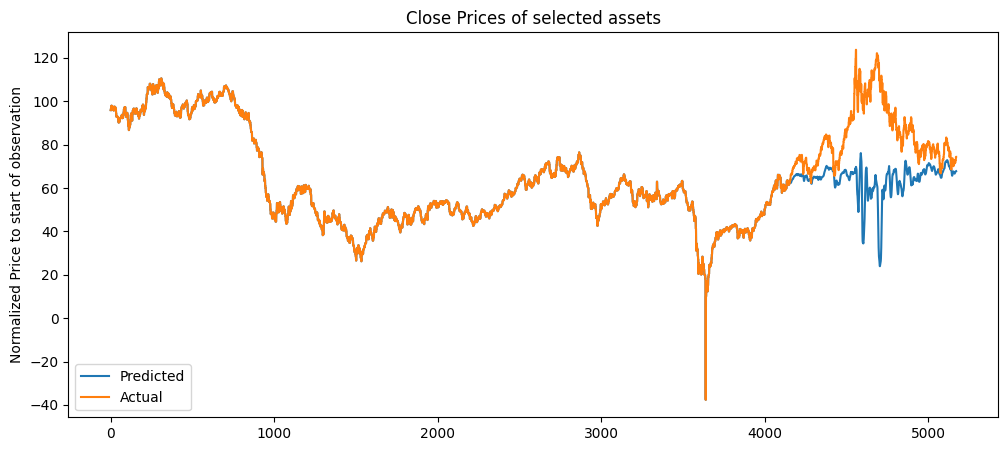

In [38]:
# EI
mse_list = []
x_list = [[int(x) for x in row.tolist()] for row in train_x_ei]

ei_data = {'x':x_list[:21],'mse':best_observed_ei}
ei_final = pd.DataFrame(ei_data)

ei_test = ei_final.loc[ei_final['mse']== (ei_final['mse'].max()),'x'].values[0]

model1_optimized_ei = LSTM_predictor(X1, Y1)
model1_optimized_ei.prepare_data(train_test_split = 0.8, timestep = 30, look_forward = 3, inplace = True)
model1_optimized_ei.init_model(optimizer='adam', loss='mean_squared_error', num_lstm_units = ei_test[0] ,num_lstm_units_2 = ei_test[1], num_dense_units = ei_test[2], learning_rate = ei_test[4])
model1_optimized_ei.fit_model_train(epochs=50,batch_size=ei_test[3],callbacks=[CustomCallback(model1_optimized_ei)])
model1_optimized_ei.predict()
model1_optimized_ei.key_metrics()
model1_optimized_ei.plot_prediction()

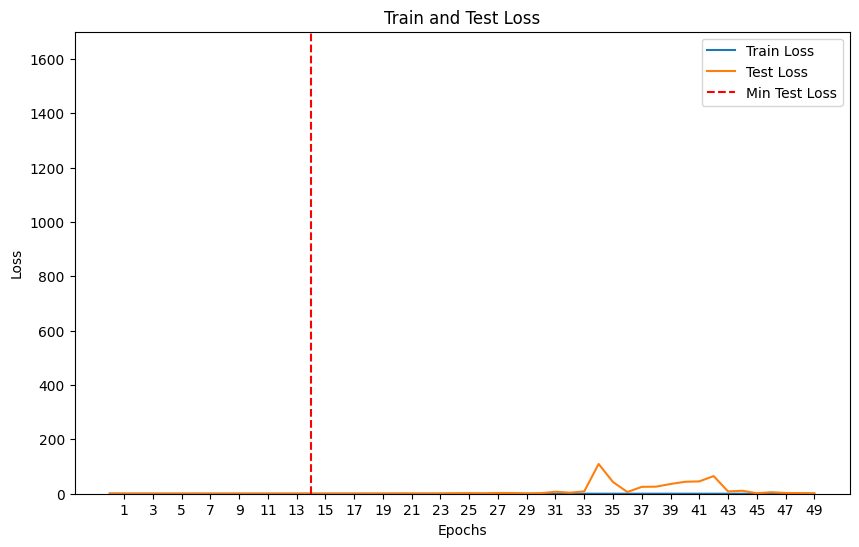

MSE: 0.3829831526929121
MAE: 0.5200487671151881
Explained ratio: 0.7139608084584298


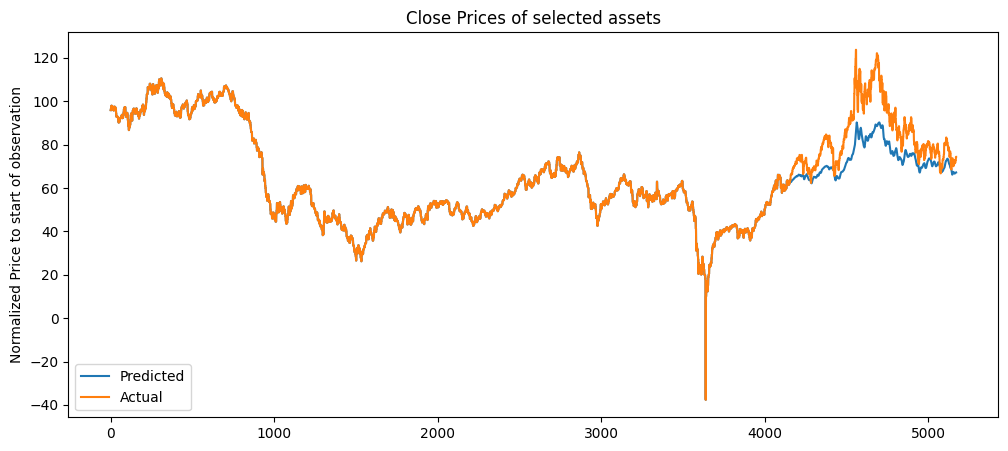

In [39]:
loss_curve(model1_optimized_ei,1700)

In [40]:
# multiple trials
# number of runs to assess std of different BO loops
N_TRIALS = 4
# indicator to print diagnostics
verbose = True
# number of steps in the outer BO loop
N_ROUND = 20
best_random_all, best_observed_ei_all, best_observed_qei_all, best_observed_ucb_all, best_observed_qkg_all = [], [], [], [], []

# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    
    best_random, best_observed_ei, best_observed_qei, best_observed_ucb, best_observed_qkg  = [], [], [], [], []
    
    # call helper functions to generate initial training data and initialize model
#     train_x, train_y, best_observed_value = generate_initial_data(n=3)
    train_x_ei = train_x
    train_x_qei = train_x
    train_x_ucb = train_x
    train_x_qkg = train_x
    train_y_ei = train_y
    train_y_qei = train_y
    train_y_ucb = train_y
    train_y_qkg = train_y

    mll_ei, model_ei = initialize_model(train_x_ei, train_y_ei)
    mll_qei, model_qei = initialize_model(train_x_qei, train_y_qei)
    mll_ucb, model_ucb = initialize_model(train_x_ucb, train_y_ucb)
    mll_qkg, model_qkg = initialize_model(train_x_qkg, train_y_qkg)

    best_random.append(best_observed_value)
    best_observed_ei.append(best_observed_value)
    best_observed_qei.append(best_observed_value)
    best_observed_ucb.append(best_observed_value)
    best_observed_qkg.append(best_observed_value)

    # run N_ROUND rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_ROUND + 1):    
        t0 = time.monotonic()
        # fit the models
        fit_gpytorch_mll(mll_ei)
        fit_gpytorch_mll(mll_qei)
        fit_gpytorch_mll(mll_ucb)
        fit_gpytorch_mll(mll_qkg)

        # for best_f, we use the best observed exact values
        EI = ExpectedImprovement(model=model_ei, best_f=train_y_ei.max())
        qEI = qExpectedImprovement(model=model_qei, 
                                  best_f=train_y_ei.max(),
                                  num_samples=1024
                                  )
        UCB = UpperConfidenceBound(model=model_ucb, beta=beta)
        qKG = qKnowledgeGradient(
            model=model_qkg,
            num_fantasies=64,
            objective=None,
            X_baseline=train_x_qkg,
        )
        
        # optimize and get new observation
        new_x_ei, new_y_ei = optimize_acqf_and_get_observation(EI)
        new_x_qei, new_y_qei = optimize_acqf_and_get_observation(qEI)
        new_x_ucb, new_y_ucb = optimize_acqf_and_get_observation(UCB)
        new_x_qkg, new_y_qkg = optimize_acqf_and_get_observation(qKG)
                
        # update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei], dim=0)
        train_x_qei = torch.cat([train_x_qei, new_x_qei], dim=0)
        train_x_ucb = torch.cat([train_x_ucb, new_x_ucb], dim=0)
        train_x_qkg = torch.cat([train_x_qkg, new_x_qkg], dim=0)
        train_y_ei = torch.cat([train_y_ei, new_y_ei], dim=0)
        train_y_qei = torch.cat([train_y_qei, new_y_qei], dim=0)
        train_y_ucb = torch.cat([train_y_ucb, new_y_ucb], dim=0)
        train_y_qkg = torch.cat([train_y_qkg, new_y_qkg], dim=0)

        # update progress
        best_random = update_random_observations(best_random)
        best_value_ei = max(best_observed_ei[-1], new_y_ei.item())  
        best_value_qei = max(best_observed_qei[-1], new_y_qei.item())  
        best_value_ucb = max(best_observed_ucb[-1], new_y_ucb.item())  
        best_value_qkg = max(best_observed_qkg[-1], new_y_qkg.item())  

        best_observed_ei.append(best_value_ei)
        best_observed_qei.append(best_value_qei)
        best_observed_ucb.append(best_value_ucb)
        best_observed_qkg.append(best_value_qkg)

        # reinitialize the models so they are ready for fitting on next iteration
        mll_ei, model_ei = initialize_model(
            train_x_ei, 
            train_y_ei
        )
        mll_qei, model_qei = initialize_model(
            train_x_qei, 
            train_y_qei
        )
        mll_ucb, model_ucb = initialize_model(
            train_x_ucb, 
            train_y_ucb
        )
        mll_qkg, model_qkg = initialize_model(
            train_x_qkg, 
            train_y_qkg
        )

        t1 = time.monotonic()
   
    best_observed_ei_all.append(best_observed_ei)
    best_observed_qei_all.append(best_observed_qei)
    best_observed_ucb_all.append(best_observed_ucb)
    best_observed_qkg_all.append(best_observed_qkg)
    best_random_all.append(best_random)

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
18/18 [==============================] - 4s 7ms/step - loss: 0.1850
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0312
Epoch 3/5
18/18 [==============================] - 0s 6ms/step - loss: 0.0198
Epoch 4/5
18/18 [==============================] - 0s 6ms/step - loss: 0.0169
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 4s 8ms/step - loss: 0.1116
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0248
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0177
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0151
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 7ms/step - loss: 0.2203
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0382
Epoch 3/5
12/12 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
20/20 [==============================] - 4s 7ms/step - loss: 0.1487
Epoch 2/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0237
Epoch 3/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0171
Epoch 4/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0154
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 8ms/step - loss: 0.1818
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0340
Epoch 3/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0212
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0171
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 5s 8ms/step - loss: 0.2118
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0340
Epoch 3/5
12/12 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 8ms/step - loss: 0.2024
Epoch 2/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0368
Epoch 3/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0215
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0181
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
16/16 [==============================] - 5s 7ms/step - loss: 0.1828
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0340
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0200
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0158
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 8ms/step - loss: 0.1563
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0294
Epoch 3/5
13/13 [==============================] - 0s 8ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
19/19 [==============================] - 5s 7ms/step - loss: 0.0927
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0246
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0193
Epoch 4/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0151
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 4s 7ms/step - loss: 0.1264
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0259
Epoch 3/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0186
Epoch 4/5
18/18 [==============================] - 0s 6ms/step - loss: 0.0156
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
17/17 [==============================] - 4s 7ms/step - loss: 0.1470
Epoch 2/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0305
Epoch 3/5
17/17 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
17/17 [==============================] - 4s 7ms/step - loss: 0.1371
Epoch 2/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0312
Epoch 3/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0201
Epoch 4/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0167
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 5s 7ms/step - loss: 0.2163
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0405
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0272
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0215
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 10ms/step - loss: 0.1936
Epoch 2/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0329
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0199
Epoch 4/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0164
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
19/19 [==============================] - 4s 8ms/step - loss: 0.2778
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0296
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0201
Epoch 4/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0151
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
17/17 [==============================] - 4s 7ms/step - loss: 0.1724
Epoch 2/5
17/17 [==============================] - 0s 6ms/step - loss: 0.0358
Epoch 3/5
17/17 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 4/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0173
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 8ms/step - loss: 0.2185
Epoch 2/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0370
Epoch 3/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0224
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0183
Epoch 5/5
15/15 [==============================] - 2s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 10ms/step - loss: 0.2478
Epoch 2/5
14/14 [==============================] - 0s 9ms/step - loss: 0.0332
Epoch 3/5
14/14 [==============================] - 0s 8ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
16/16 [==============================] - 4s 8ms/step - loss: 0.1194
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0213
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0184
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0169
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 8ms/step - loss: 0.2094
Epoch 2/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0417
Epoch 3/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0224
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0183
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 9ms/step - loss: 0.2090
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0279
Epoch 3/5
11/11 [==============================] - 0s 9ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
13/13 [==============================] - 4s 9ms/step - loss: 0.1767
Epoch 2/5
13/13 [==============================] - 0s 9ms/step - loss: 0.0278
Epoch 3/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0200
Epoch 4/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0167
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 8ms/step - loss: 0.1482
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0280
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0210
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 5s 8ms/step - loss: 0.1717
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0278
Epoch 3/5
12/12 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
13/13 [==============================] - 4s 9ms/step - loss: 0.1697
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0279
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0210
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0179
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 5s 11ms/step - loss: 0.2411
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0304
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0213
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
16/16 [==============================] - 4s 8ms/step - loss: 0.2291
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0346
Epoch 3/5
16/16 [==============================] - 0s 6ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
16/16 [==============================] - 4s 9ms/step - loss: 0.1532
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0296
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0200
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0155
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
17/17 [==============================] - 4s 9ms/step - loss: 0.1428
Epoch 2/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0246
Epoch 3/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0168
Epoch 4/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0153
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
16/16 [==============================] - 5s 9ms/step - loss: 0.1408
Epoch 2/5
16/16 [==============================] - 0s 8ms/step - loss: 0.0253
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0180
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0147
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
20/20 [==============================] - 4s 9ms/step - loss: 0.2445
Epoch 2/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0223
Epoch 3/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0196
Epoch 4/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0156
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 10ms/step - loss: 0.2641
Epoch 2/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0384
Epoch 3/5
11/11 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
14/14 [==============================] - 4s 9ms/step - loss: 0.1822
Epoch 2/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0344
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0242
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0179
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
17/17 [==============================] - 4s 9ms/step - loss: 0.1492
Epoch 2/5
17/17 [==============================] - 0s 8ms/step - loss: 0.0252
Epoch 3/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0222
Epoch 4/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0166
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 12ms/step - loss: 0.2659
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0436
Epoch 3/5
11/11 [==============================] - 0s 8ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
13/13 [==============================] - 4s 9ms/step - loss: 0.1848
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0290
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0217
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0163
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 10ms/step - loss: 0.2155
Epoch 2/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0353
Epoch 3/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0202
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0168
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 11ms/step - loss: 0.2291
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0385
Epoch 3/5
11/11 [==============================] - 0s 8ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
12/12 [==============================] - 4s 10ms/step - loss: 0.1819
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0357
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0232
Epoch 4/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0172
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
17/17 [==============================] - 4s 8ms/step - loss: 0.1403
Epoch 2/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0224
Epoch 3/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0198
Epoch 4/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.2060
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0310
Epoch 3/5
12/12 [==============================] - 0s 9ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
17/17 [==============================] - 4s 10ms/step - loss: 0.1377
Epoch 2/5
17/17 [==============================] - 0s 8ms/step - loss: 0.0223
Epoch 3/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0189
Epoch 4/5
17/17 [==============================] - 0s 8ms/step - loss: 0.0155
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 9ms/step - loss: 0.1519
Epoch 2/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0303
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0194
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0165
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 5s 8ms/step - loss: 0.1639
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0293
Epoch 3/5
18/18 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 11ms/step - loss: 0.1790
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0367
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0233
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0181
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 5s 9ms/step - loss: 0.1429
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0240
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0188
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0147
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 12ms/step - loss: 0.2460
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0320
Epoch 3/5
11/11 [==============================] - 0s 9ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
16/16 [==============================] - 5s 10ms/step - loss: 0.1525
Epoch 2/5
16/16 [==============================] - 0s 8ms/step - loss: 0.0234
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0216
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0167
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
19/19 [==============================] - 4s 9ms/step - loss: 0.1723
Epoch 2/5
19/19 [==============================] - 0s 8ms/step - loss: 0.0238
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0195
Epoch 4/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0155
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 9ms/step - loss: 0.2410
Epoch 2/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0418
Epoch 3/5
11/11 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
19/19 [==============================] - 4s 9ms/step - loss: 0.1091
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0208
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0172
Epoch 4/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0151
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 9ms/step - loss: 0.2467
Epoch 2/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0439
Epoch 3/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0283
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0221
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
12/12 [==============================] - 4s 10ms/step - loss: 0.2100
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0328
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0236
Epoch 4/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0178
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
14/14 [==============================] - 4s 8ms/step - loss: 0.1422
Epoch 2/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0287
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0239
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0168
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 5s 11ms/step - loss: 0.2756
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0430
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0278
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0214
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
16/16 [==============================] - 4s 9ms/step - loss: 0.1567
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0213
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0156
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
21/21 [==============================] - 4s 8ms/step - loss: 0.0951
Epoch 2/5
21/21 [==============================] - 0s 7ms/step - loss: 0.0238
Epoch 3/5
21/21 [==============================] - 0s 7ms/step - loss: 0.0177
Epoch 4/5
21/21 [==============================] - 0s 6ms/step - loss: 0.0145
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.2040
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0388
Epoch 3/5
12/12 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 14ms/step - loss: 0.3088
Epoch 2/5
11/11 [==============================] - 0s 12ms/step - loss: 0.0399
Epoch 3/5
11/11 [==============================] - 0s 11ms/step - loss: 0.0206
Epoch 4/5
11/11 [==============================] - 0s 11ms/step - loss: 0.0168
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 4s 9ms/step - loss: 0.1624
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0343
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0236
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0172
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 5s 10ms/step - loss: 0.2215
Epoch 2/5
15/15 [==============================] - 0s 9ms/step - loss: 0.0304
Epoch 3/5
15/15 [==============================] - 0s 8ms

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
16/16 [==============================] - 4s 9ms/step - loss: 0.1186
Epoch 2/5
16/16 [==============================] - 0s 8ms/step - loss: 0.0238
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0169
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0159
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 9ms/step - loss: 0.1880
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0362
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0262
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0199
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
14/14 [==============================] - 5s 9ms/step - loss: 0.1089
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0251
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0219
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0170
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.2889
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0458
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0268
Epoch 4/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0219
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
16/16 [==============================] - 4s 10ms/step - loss: 0.2867
Epoch 2/5
16/16 [==============================] - 0s 8ms/step - loss: 0.0319
Epoch 3/5
16/16 [==============================] - 0s 8ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
13/13 [==============================] - 4s 10ms/step - loss: 0.1515
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0275
Epoch 3/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0199
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0158
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
19/19 [==============================] - 5s 9ms/step - loss: 0.1341
Epoch 2/5
19/19 [==============================] - 0s 8ms/step - loss: 0.0265
Epoch 3/5
19/19 [==============================] - 0s 8ms/step - loss: 0.0184
Epoch 4/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0148
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 4s 9ms/step - loss: 0.1372
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0308
Epoch 3/5
15/15 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 6s 10ms/step - loss: 0.1540
Epoch 2/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0305
Epoch 3/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0213
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0178
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.2144
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0375
Epoch 3/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0243
Epoch 4/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0192
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 4s 11ms/step - loss: 0.2908
Epoch 2/5
15/15 [==============================] - 0s 10ms/step - loss: 0.0372
Epoch 3/5
15/15 [==============================] - 0s 9ms/

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 9ms/step - loss: 0.1916
Epoch 2/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0460
Epoch 3/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0274
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0217
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
21/21 [==============================] - 4s 8ms/step - loss: 0.1301
Epoch 2/5
21/21 [==============================] - 0s 7ms/step - loss: 0.0251
Epoch 3/5
21/21 [==============================] - 0s 7ms/step - loss: 0.0177
Epoch 4/5
21/21 [==============================] - 0s 7ms/step - loss: 0.0158
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
16/16 [==============================] - 4s 8ms/step - loss: 0.1822
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0283
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0189
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0164
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 10ms/step - loss: 0.1955
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0290
Epoch 3/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0226
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0190
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 5s 9ms/step - loss: 0.2281
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0377
Epoch 3/5
13/13 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
12/12 [==============================] - 4s 10ms/step - loss: 0.1990
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0369
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0222
Epoch 4/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0167
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 9ms/step - loss: 0.1810
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0350
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0203
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0182
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.2915
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0398
Epoch 3/5
12/12 [==============================] - 0s 8ms/st

/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
15/15 [==============================] - 5s 8ms/step - loss: 0.0899
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0259
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0171
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0154
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 4s 10ms/step - loss: 0.2119
Epoch 2/5
18/18 [==============================] - 0s 8ms/step - loss: 0.0272
Epoch 3/5
18/18 [==============================] - 0s 8ms/step - loss: 0.0217
Epoch 4/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0151
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
15/15 [==============================] - 4s 10ms/step - loss: 0.1343
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0272
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0223
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0184
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 9ms/step - loss: 0.2224
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0336
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0210
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0182
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 10ms/step - loss: 0.1485
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0307
Epoch 3/5
14/14 [==============================] - 0s 7ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
14/14 [==============================] - 4s 9ms/step - loss: 0.1226
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0275
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0216
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0162
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
17/17 [==============================] - 4s 9ms/step - loss: 0.2076
Epoch 2/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0325
Epoch 3/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0204
Epoch 4/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0161
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 5s 9ms/step - loss: 0.1326
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0228
Epoch 3/5
13/13 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
13/13 [==============================] - 4s 8ms/step - loss: 0.1869
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0380
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0214
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0170
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 6s 8ms/step - loss: 0.1911
Epoch 2/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0332
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0211
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0180
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.1515
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0285
Epoch 3/5
12/12 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
14/14 [==============================] - 4s 9ms/step - loss: 0.1517
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0292
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0185
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0155
Epoch 5/5
15/15 [==============================] - 2s 4ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 10ms/step - loss: 0.2505
Epoch 2/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0418
Epoch 3/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0260
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0194
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
16/16 [==============================] - 4s 8ms/step - loss: 0.1896
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0307
Epoch 3/5
16/16 [==============================] - 0s 6ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
16/16 [==============================] - 6s 9ms/step - loss: 0.1010
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0280
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0181
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.2153
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0408
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0234
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0200
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
17/17 [==============================] - 4s 9ms/step - loss: 0.1669
Epoch 2/5
17/17 [==============================] - 0s 8ms/step - loss: 0.0274
Epoch 3/5
17/17 [==============================] - 0s 8ms/step

/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
18/18 [==============================] - 4s 8ms/step - loss: 0.1629
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0266
Epoch 3/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0198
Epoch 4/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0158
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 6s 10ms/step - loss: 0.2058
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0361
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0215
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0176
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
13/13 [==============================] - 4s 10ms/step - loss: 0.1461
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0287
Epoch 3/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0261
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0184
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 10ms/step - loss: 0.1745
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0302
Epoch 3/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0212
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0161
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 10ms/step - loss: 0.1455
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0280
Epoch 3/5
13/13 [==============================] - 0s 7ms/s

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.2095
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0536
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0281
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0215
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 4s 10ms/step - loss: 0.2325
Epoch 2/5
18/18 [==============================] - 0s 9ms/step - loss: 0.0272
Epoch 3/5
18/18 [==============================] - 0s 8ms/step - loss: 0.0210
Epoch 4/5
18/18 [==============================] - 0s 8ms/step - loss: 0.0157
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
15/15 [==============================] - 4s 10ms/step - loss: 0.1124
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0204
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0207
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0162
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 5s 9ms/step - loss: 0.2796
Epoch 2/5
18/18 [==============================] - 0s 8ms/step - loss: 0.0286
Epoch 3/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0185
Epoch 4/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0164
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 4s 9ms/step - loss: 0.2790
Epoch 2/5
18/18 [==============================] - 0s 8ms/step - loss: 0.0309
Epoch 3/5
18/18 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
14/14 [==============================] - 4s 9ms/step - loss: 0.1838
Epoch 2/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0290
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0221
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0169
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 10ms/step - loss: 0.2022
Epoch 2/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0343
Epoch 3/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0199
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0172
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
16/16 [==============================] - 4s 8ms/step - loss: 0.1572
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0265
Epoch 3/5
16/16 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
13/13 [==============================] - 4s 9ms/step - loss: 0.2389
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0385
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0239
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0198
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
19/19 [==============================] - 4s 8ms/step - loss: 0.0970
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0233
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0204
Epoch 4/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0153
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
11/11 [==============================] - 5s 12ms/step - loss: 0.3006
Epoch 2/5
11/11 [==============================] - 0s 11ms/step - loss: 0.0449
Epoch 3/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0284
Epoch 4/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0213
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
13/13 [==============================] - 4s 12ms/step - loss: 0.2486
Epoch 2/5
13/13 [==============================] - 0s 10ms/step - loss: 0.0375
Epoch 3/5
13/13 [==============================] - 0s 9ms/step - loss: 0.0218
Epoch 4/5
13/13 [==============================] - 0s 9ms/step - loss: 0.0169
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 8ms/step - loss: 0.1398
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0315
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0192
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0165
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 11ms/step - loss: 0.2662
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0417
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0216
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0166
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 5s 9ms/step - loss: 0.2535
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0381
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0254
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0191
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
11/11 [==============================] - 4s 11ms/step - loss: 0.4006
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0440
Epoch 3/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0223
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0167
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
16/16 [==============================] - 4s 8ms/step - loss: 0.0984
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0259
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0188
Epoch 4/5
16/16 [==============================] - 0s 6ms/step - loss: 0.0173
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
19/19 [==============================] - 4s 9ms/step - loss: 0.1138
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0203
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0173
Epoch 4/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
14/14 [==============================] - 6s 8ms/step - loss: 0.2183
Epoch 2/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0344
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0222
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0167
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 11ms/step - loss: 0.2750
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0376
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0209
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0155
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 10ms/step - loss: 0.1901
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0364
Epoch 3/5
12/12 [==============================] - 0s 8ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
16/16 [==============================] - 6s 8ms/step - loss: 0.2343
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0366
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0202
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0178
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
20/20 [==============================] - 4s 9ms/step - loss: 0.1516
Epoch 2/5
20/20 [==============================] - 0s 8ms/step - loss: 0.0260
Epoch 3/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0190
Epoch 4/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0159
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
19/19 [==============================] - 4s 8ms/step - loss: 0.1317
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0283
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0172
Epoch 4/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0155
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 10ms/step - loss: 0.1943
Epoch 2/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0313
Epoch 3/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0219
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0189
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
16/16 [==============================] - 6s 8ms/step - loss: 0.1916
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0367
Epoch 3/5
16/16 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 12ms/step - loss: 0.3543
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0404
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0196
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0165
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 10ms/step - loss: 0.2939
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0388
Epoch 3/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0261
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0201
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
17/17 [==============================] - 4s 9ms/step - loss: 0.1586
Epoch 2/5
17/17 [==============================] - 0s 8ms/step - loss: 0.0280
Epoch 3/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0216
Epoch 4/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0178
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
12/12 [==============================] - 6s 9ms/step - loss: 0.1649
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0307
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0220
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0167
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 9ms/step - loss: 0.2073
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0321
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0198
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0168
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
18/18 [==============================] - 4s 9ms/step - loss: 0.1741
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0237
Epoch 3/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0202
Epoch 4/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0154
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 4s 9ms/step - loss: 0.1688
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0232
Epoch 3/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0186
Epoch 4/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0145
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 4s 9ms/step - loss: 0.2097
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0273
Epoch 3/5
18/18 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
16/16 [==============================] - 4s 9ms/step - loss: 0.1592
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0272
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0182
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 8ms/step - loss: 0.1983
Epoch 2/5
14/14 [==============================] - 0s 6ms/step - loss: 0.0358
Epoch 3/5
14/14 [==============================] - 0s 6ms/step - loss: 0.0209
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0188
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
13/13 [==============================] - 5s 9ms/step - loss: 0.1387
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0284
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0176
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0151
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 10ms/step - loss: 0.1512
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0282
Epoch 3/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0174
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0167
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 10ms/step - loss: 0.1321
Epoch 2/5
14/14 [==============================] - 0s 9ms/step - loss: 0.0269
Epoch 3/5
14/14 [==============================] - 0s 8ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
19/19 [==============================] - 4s 8ms/step - loss: 0.1427
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0250
Epoch 3/5
19/19 [==============================] - 0s 6ms/step - loss: 0.0200
Epoch 4/5
19/19 [==============================] - 0s 6ms/step - loss: 0.0161
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 10ms/step - loss: 0.2054
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0331
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0200
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 5/5
15/15 [==============================] - 2s 4ms/step
(459,)
(459, 1)
Epoch 1/5
17/17 [==============================] - 4s 9ms/step - loss: 0.1291
Epoch 2/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0250
Epoch 3/5
17/17 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
13/13 [==============================] - 4s 10ms/step - loss: 0.1605
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0312
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0204
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0167
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.1694
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0334
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0268
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0195
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
19/19 [==============================] - 4s 8ms/step - loss: 0.1619
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0274
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0192
Epoch 4/5
19/19 [==============================] - 0s 6ms/step - loss: 0.0152
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 5s 11ms/step - loss: 0.2060
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0306
Epoch 3/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0194
Epoch 4/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0161
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 9ms/step - loss: 0.1984
Epoch 2/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0359
Epoch 3/5
11/11 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 5s 9ms/step - loss: 0.1683
Epoch 2/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0358
Epoch 3/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0225
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0173
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 11ms/step - loss: 0.1679
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0343
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0192
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0152
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 10ms/step - loss: 0.1232
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0256
Epoch 3/5
13/13 [==============================] - 0s 8ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.1789
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0337
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0227
Epoch 4/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0178
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 10ms/step - loss: 0.1876
Epoch 2/5
14/14 [==============================] - 0s 9ms/step - loss: 0.0296
Epoch 3/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0188
Epoch 4/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0168
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
19/19 [==============================] - 4s 9ms/step - loss: 0.2616
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0276
Epoch 3/5
19/19 [==============================] - 0s 7ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
18/18 [==============================] - 4s 9ms/step - loss: 0.2136
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0291
Epoch 3/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0192
Epoch 4/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0156
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 9ms/step - loss: 0.1848
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0294
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0223
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0167
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.2287
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0341
Epoch 3/5
12/12 [==============================] - 0s 9ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
17/17 [==============================] - 4s 9ms/step - loss: 0.1879
Epoch 2/5
17/17 [==============================] - 0s 8ms/step - loss: 0.0285
Epoch 3/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0220
Epoch 4/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0169
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.2916
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0382
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0246
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0190
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 10ms/step - loss: 0.1843
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0351
Epoch 3/5
12/12 [==============================] - 0s 8ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 9ms/step - loss: 0.1965
Epoch 2/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0341
Epoch 3/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0201
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0167
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
20/20 [==============================] - 4s 9ms/step - loss: 0.1653
Epoch 2/5
20/20 [==============================] - 0s 8ms/step - loss: 0.0254
Epoch 3/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0171
Epoch 4/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0148
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 6s 10ms/step - loss: 0.2002
Epoch 2/5
18/18 [==============================] - 0s 9ms/step - loss: 0.0274
Epoch 3/5
18/18 [==============================] - 0s 8ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


Epoch 1/5
16/16 [==============================] - 4s 9ms/step - loss: 0.1324
Epoch 2/5
16/16 [==============================] - 0s 8ms/step - loss: 0.0271
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0225
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0155
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 6s 10ms/step - loss: 0.1486
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0305
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0208
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0179
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 10ms/step - loss: 0.2168
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0306
Epoch 3/5
14/14 [==============================] - 0s 8ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.1958
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0303
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0219
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0174
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 4s 9ms/step - loss: 0.1167
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0240
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0228
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0172
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 12ms/step - loss: 0.2646
Epoch 2/5
12/12 [==============================] - 0s 10ms/step - loss: 0.0371
Epoch 3/5
12/12 [==============================] - 0s 9ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
18/18 [==============================] - 6s 8ms/step - loss: 0.1209
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0254
Epoch 3/5
18/18 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 4/5
18/18 [==============================] - 0s 6ms/step - loss: 0.0155
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
16/16 [==============================] - 4s 9ms/step - loss: 0.2488
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0441
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0227
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0166
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
13/13 [==============================] - 4s 9ms/step - loss: 0.1817
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0295
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0187
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0154
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 10ms/step - loss: 0.1565
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0305
Epoch 3/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0203
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0158
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
20/20 [==============================] - 4s 9ms/step - loss: 0.2781
Epoch 2/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0241
Epoch 3/5
20/20 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 11ms/step - loss: 0.2485
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0383
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0215
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0165
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 4s 8ms/step - loss: 0.1921
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0317
Epoch 3/5
15/15 [==============================] - 0s 6ms/step - loss: 0.0209
Epoch 4/5
15/15 [==============================] - 0s 6ms/step - loss: 0.0174
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
14/14 [==============================] - 4s 11ms/step - loss: 0.2626
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0308
Epoch 3/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0202
Epoch 4/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0174
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.2240
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0393
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0219
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0177
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
19/19 [==============================] - 6s 8ms/step - loss: 0.1446
Epoch 2/5
19/19 [==============================] - 0s 6ms/step - loss: 0.0279
Epoch 3/5
19/19 [==============================] - 0s 6ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.2070
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0365
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0210
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0181
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 9ms/step - loss: 0.1564
Epoch 2/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0314
Epoch 3/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0228
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0180
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
17/17 [==============================] - 4s 10ms/step - loss: 0.2074
Epoch 2/5
17/17 [==============================] - 0s 8ms/step - loss: 0.0294
Epoch 3/5
17/17 [==============================] - 0s 8ms/step - loss: 0.0202
Epoch 4/5
17/17 [==============================] - 0s 8ms/step - loss: 0.0152
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
19/19 [==============================] - 4s 8ms/step - loss: 0.2185
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0233
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0196
Epoch 4/5
19/19 [==============================] - 0s 6ms/step - loss: 0.0166
Epoch 5/5
15/15 [==============================] - 2s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 4s 11ms/step - loss: 0.2051
Epoch 2/5
15/15 [==============================] - 0s 9ms/step - loss: 0.0286
Epoch 3/5
15/15 [==============================] - 0s 8ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.3221
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0401
Epoch 3/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0240
Epoch 4/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0174
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 9ms/step - loss: 0.2188
Epoch 2/5
14/14 [==============================] - 0s 6ms/step - loss: 0.0353
Epoch 3/5
14/14 [==============================] - 0s 6ms/step - loss: 0.0206
Epoch 4/5
14/14 [==============================] - 0s 6ms/step - loss: 0.0170
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
13/13 [==============================] - 4s 10ms/step - loss: 0.1585
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0294
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0213
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0155
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
20/20 [==============================] - 6s 9ms/step - loss: 0.1376
Epoch 2/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0252
Epoch 3/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0179
Epoch 4/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0163
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 4s 10ms/step - loss: 0.2856
Epoch 2/5
18/18 [==============================] - 0s 9ms/step - loss: 0.0303
Epoch 3/5
18/18 [==============================] - 0s 8ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
13/13 [==============================] - 4s 9ms/step - loss: 0.1855
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0325
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0203
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0168
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 8ms/step - loss: 0.1652
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0290
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0215
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0162
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 6s 10ms/step - loss: 0.1507
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0245
Epoch 3/5
14/14 [==============================] - 0s 8ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.1805
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0332
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0219
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0176
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
20/20 [==============================] - 4s 8ms/step - loss: 0.1333
Epoch 2/5
20/20 [==============================] - 0s 6ms/step - loss: 0.0226
Epoch 3/5
20/20 [==============================] - 0s 6ms/step - loss: 0.0202
Epoch 4/5
20/20 [==============================] - 0s 6ms/step - loss: 0.0155
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 6s 11ms/step - loss: 0.1810
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0277
Epoch 3/5
13/13 [==============================] - 0s 8ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
14/14 [==============================] - 4s 9ms/step - loss: 0.1696
Epoch 2/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0325
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0183
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0166
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 6s 8ms/step - loss: 0.1709
Epoch 2/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0294
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0204
Epoch 4/5
14/14 [==============================] - 0s 6ms/step - loss: 0.0171
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
16/16 [==============================] - 4s 8ms/step - loss: 0.1151
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0279
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0173
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0161
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.2486
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0370
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0225
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0181
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
20/20 [==============================] - 4s 7ms/step - loss: 0.1422
Epoch 2/5
20/20 [==============================] - 0s 6ms/step - loss: 0.0274
Epoch 3/5
20/20 [==============================] - 0s 6ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
18/18 [==============================] - 4s 9ms/step - loss: 0.1958
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0285
Epoch 3/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0201
Epoch 4/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 5/5
15/15 [==============================] - 2s 4ms/step
(459,)
(459, 1)
Epoch 1/5
20/20 [==============================] - 4s 8ms/step - loss: 0.1767
Epoch 2/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0272
Epoch 3/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0183
Epoch 4/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 11ms/step - loss: 0.2495
Epoch 2/5
13/13 [==============================] - 0s 9ms/step - loss: 0.0376
Epoch 3/5
13/13 [==============================] - 0s 8ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
21/21 [==============================] - 4s 7ms/step - loss: 0.1360
Epoch 2/5
21/21 [==============================] - 0s 6ms/step - loss: 0.0287
Epoch 3/5
21/21 [==============================] - 0s 6ms/step - loss: 0.0192
Epoch 4/5
21/21 [==============================] - 0s 6ms/step - loss: 0.0153
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.2018
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0311
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0180
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0161
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
18/18 [==============================] - 6s 9ms/step - loss: 0.1611
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0284
Epoch 3/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0199
Epoch 4/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0167
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 10ms/step - loss: 0.2153
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0362
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0255
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0193
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 11ms/step - loss: 0.2359
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0442
Epoch 3/5
11/11 [==============================] - 0s 8ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 11ms/step - loss: 0.2064
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0366
Epoch 3/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0231
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0181
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
17/17 [==============================] - 4s 11ms/step - loss: 0.3065
Epoch 2/5
17/17 [==============================] - 0s 9ms/step - loss: 0.0313
Epoch 3/5
17/17 [==============================] - 0s 8ms/step - loss: 0.0227
Epoch 4/5
17/17 [==============================] - 0s 8ms/step - loss: 0.0168
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 4s 8ms/step - loss: 0.1021
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0197
Epoch 3/5
18/18 [==============================] - 0s 7ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.1946
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0294
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0201
Epoch 4/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0171
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
17/17 [==============================] - 4s 8ms/step - loss: 0.1686
Epoch 2/5
17/17 [==============================] - 0s 6ms/step - loss: 0.0290
Epoch 3/5
17/17 [==============================] - 0s 6ms/step - loss: 0.0194
Epoch 4/5
17/17 [==============================] - 0s 6ms/step - loss: 0.0163
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.2410
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0362
Epoch 3/5
12/12 [==============================] - 0s 8ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
14/14 [==============================] - 4s 10ms/step - loss: 0.1446
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0268
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0252
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0163
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 8ms/step - loss: 0.2703
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0445
Epoch 3/5
13/13 [==============================] - 0s 6ms/step - loss: 0.0260
Epoch 4/5
13/13 [==============================] - 0s 6ms/step - loss: 0.0194
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 9ms/step - loss: 0.1684
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0279
Epoch 3/5
13/13 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
17/17 [==============================] - 4s 10ms/step - loss: 0.1662
Epoch 2/5
17/17 [==============================] - 0s 8ms/step - loss: 0.0255
Epoch 3/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0165
Epoch 4/5
17/17 [==============================] - 0s 8ms/step - loss: 0.0155
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 10ms/step - loss: 0.2280
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0318
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0192
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
15/15 [==============================] - 6s 9ms/step - loss: 0.1174
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0243
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0237
Epoch 4/5
15/15 [==============================] - 0s 6ms/step - loss: 0.0170
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
17/17 [==============================] - 4s 8ms/step - loss: 0.2048
Epoch 2/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0385
Epoch 3/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0228
Epoch 4/5
17/17 [==============================] - 0s 7ms/step - loss: 0.0184
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
20/20 [==============================] - 4s 10ms/step - loss: 0.1953
Epoch 2/5
20/20 [==============================] - 0s 8ms/step - loss: 0.0222
Epoch 3/5
20/20 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 13ms/step - loss: 0.1939
Epoch 2/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0348
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0228
Epoch 4/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0187
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 6s 9ms/step - loss: 0.2176
Epoch 2/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0330
Epoch 3/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0238
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0177
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 9ms/step - loss: 0.1868
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0323
Epoch 3/5
13/13 [==============================] - 0s 7ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.3117
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0430
Epoch 3/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0225
Epoch 4/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0169
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 6s 8ms/step - loss: 0.1421
Epoch 2/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0287
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0193
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0154
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
19/19 [==============================] - 4s 8ms/step - loss: 0.1438
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0244
Epoch 3/5
19/19 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
11/11 [==============================] - 4s 9ms/step - loss: 0.2536
Epoch 2/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0500
Epoch 3/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0259
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0201
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.1944
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0374
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0233
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0197
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
18/18 [==============================] - 6s 10ms/step - loss: 0.1422
Epoch 2/5
18/18 [==============================] - 0s 8ms/step - loss: 0.0235
Epoch 3/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0187
Epoch 4/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0161
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 9ms/step - loss: 0.1780
Epoch 2/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0300
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0188
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 10ms/step - loss: 0.2035
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0394
Epoch 3/5
12/12 [==============================] - 0s 8ms/st

/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
18/18 [==============================] - 4s 8ms/step - loss: 0.1558
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0251
Epoch 3/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0190
Epoch 4/5
18/18 [==============================] - 0s 6ms/step - loss: 0.0165
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 11ms/step - loss: 0.1744
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0358
Epoch 3/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0235
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0188
Epoch 5/5
15/15 [==============================] - 2s 4ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 12ms/step - loss: 0.2348
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0372
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0242
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0202
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 4s 8ms/step - loss: 0.1678
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0325
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0210
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0164
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
20/20 [==============================] - 4s 9ms/step - loss: 0.1949
Epoch 2/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0222
Epoch 3/5
20/20 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
13/13 [==============================] - 4s 10ms/step - loss: 0.1368
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0268
Epoch 3/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0188
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0164
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.2088
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0328
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0198
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0173
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.2527
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0398
Epoch 3/5
12/12 [==============================] - 0s 8ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
19/19 [==============================] - 4s 9ms/step - loss: 0.1640
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0262
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0214
Epoch 4/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0166
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 10ms/step - loss: 0.2194
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0330
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0202
Epoch 4/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0167
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
13/13 [==============================] - 4s 11ms/step - loss: 0.1864
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0282
Epoch 3/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0173
Epoch 4/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0156
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
20/20 [==============================] - 6s 8ms/step - loss: 0.1486
Epoch 2/5
20/20 [==============================] - 0s 6ms/step - loss: 0.0291
Epoch 3/5
20/20 [==============================] - 0s 6ms/step - loss: 0.0190
Epoch 4/5
20/20 [==============================] - 0s 6ms/step - loss: 0.0161
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
16/16 [==============================] - 4s 9ms/step - loss: 0.1440
Epoch 2/5
16/16 [==============================] - 0s 8ms/step - loss: 0.0284
Epoch 3/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0175
Epoch 4/5
16/16 [==============================] - 0s 8ms/step - loss: 0.0155
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
11/11 [==============================] - 4s 10ms/step - loss: 0.2368
Epoch 2/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0436
Epoch 3/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0246
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0219
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
19/19 [==============================] - 4s 8ms/step - loss: 0.1657
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0278
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0199
Epoch 4/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0157
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 6s 12ms/step - loss: 0.2156
Epoch 2/5
12/12 [==============================] - 0s 10ms/step - loss: 0.0317
Epoch 3/5
12/12 [==============================] - 0s 8ms/s

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
12/12 [==============================] - 4s 10ms/step - loss: 0.1782
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0311
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0222
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0175
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
20/20 [==============================] - 4s 9ms/step - loss: 0.1053
Epoch 2/5
20/20 [==============================] - 0s 8ms/step - loss: 0.0220
Epoch 3/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0166
Epoch 4/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 4s 8ms/step - loss: 0.1230
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0239
Epoch 3/5
18/18 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.1863
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0288
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0209
Epoch 4/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0165
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
19/19 [==============================] - 6s 8ms/step - loss: 0.1295
Epoch 2/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0272
Epoch 3/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0198
Epoch 4/5
19/19 [==============================] - 0s 7ms/step - loss: 0.0156
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
16/16 [==============================] - 4s 9ms/step - loss: 0.1373
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0260
Epoch 3/5
16/16 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
20/20 [==============================] - 4s 9ms/step - loss: 0.1255
Epoch 2/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0223
Epoch 3/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0194
Epoch 4/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 4s 8ms/step - loss: 0.1808
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0311
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0246
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0183
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
14/14 [==============================] - 6s 10ms/step - loss: 0.2006
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0315
Epoch 3/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0206
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0171
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 4s 10ms/step - loss: 0.1329
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0305
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0184
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0153
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 4s 8ms/step - loss: 0.1450
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0252
Epoch 3/5
18/18 [==============================] - 0s 6ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
16/16 [==============================] - 6s 11ms/step - loss: 0.2173
Epoch 2/5
16/16 [==============================] - 0s 8ms/step - loss: 0.0248
Epoch 3/5
16/16 [==============================] - 0s 8ms/step - loss: 0.0189
Epoch 4/5
16/16 [==============================] - 0s 8ms/step - loss: 0.0161
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
15/15 [==============================] - 4s 10ms/step - loss: 0.1416
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0219
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0231
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0173
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 4s 8ms/step - loss: 0.1592
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0271
Epoch 3/5
18/18 [==============================] - 0s 6ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
13/13 [==============================] - 4s 9ms/step - loss: 0.1679
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0319
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0190
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0164
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.1817
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0295
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0200
Epoch 4/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0162
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
12/12 [==============================] - 4s 10ms/step - loss: 0.1520
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0285
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0227
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0170
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
13/13 [==============================] - 4s 10ms/step - loss: 0.1391
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0260
Epoch 3/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0170
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0154
Epoch 5/5
15/15 [==============================] - 2s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 10ms/step - loss: 0.1727
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0303
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0210
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0176
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
15/15 [==============================] - 4s 9ms/step - loss: 0.1034
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0199
Epoch 3/5
15/15 [==============================] - 0s 8ms/step - loss: 0.0171
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0152
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
20/20 [==============================] - 4s 8ms/step - loss: 0.1257
Epoch 2/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0253
Epoch 3/5
20/20 [==============================] - 0s 6ms/step - loss: 0.0187
Epoch 4/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0164
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.2039
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0310
Epoch 3/5
12/12 [==============================] - 0s 8ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
15/15 [==============================] - 4s 8ms/step - loss: 0.1297
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0316
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0194
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0161
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 9ms/step - loss: 0.1986
Epoch 2/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0301
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0217
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0171
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
13/13 [==============================] - 6s 9ms/step - loss: 0.1423
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0288
Epoch 3/5
13/13 [==============================] - 0s 7ms/step

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
16/16 [==============================] - 4s 10ms/step - loss: 0.1488
Epoch 2/5
16/16 [==============================] - 0s 8ms/step - loss: 0.0224
Epoch 3/5
16/16 [==============================] - 0s 8ms/step - loss: 0.0198
Epoch 4/5
16/16 [==============================] - 0s 7ms/step - loss: 0.0176
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 10ms/step - loss: 0.2108
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0339
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0199
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0164
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 6s 9ms/step - loss: 0.2092
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0388
Epoch 3/5
12/12 [==============================] - 0s 7ms/st

/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
14/14 [==============================] - 4s 10ms/step - loss: 0.1541
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0287
Epoch 3/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0212
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0178
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 9ms/step - loss: 0.1439
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0291
Epoch 3/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0186
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0152
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
20/20 [==============================] - 4s 9ms/step - loss: 0.1745
Epoch 2/5
20/20 [==============================] - 0s 8ms/step - loss: 0.0223
Epoch 3/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0171
Epoch 4/5
20/20 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 10ms/step - loss: 0.1547
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0327
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0186
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0163
Epoch 5/5
15/15 [==============================] - 3s 4ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 10ms/step - loss: 0.1550
Epoch 2/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0272
Epoch 3/5
11/11 [==============================] - 0s 8ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.1654
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0333
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0219
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0170
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 6s 9ms/step - loss: 0.2372
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0426
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0261
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0199
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)


/usr/local/lib/python3.10/dist-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5
15/15 [==============================] - 4s 9ms/step - loss: 0.1507
Epoch 2/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0299
Epoch 3/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0213
Epoch 4/5
15/15 [==============================] - 0s 7ms/step - loss: 0.0164
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.2177
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0338
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0222
Epoch 4/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0180
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 9ms/step - loss: 0.1515
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0302
Epoch 3/5
12/12 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
14/14 [==============================] - 6s 11ms/step - loss: 0.1664
Epoch 2/5
14/14 [==============================] - 0s 9ms/step - loss: 0.0258
Epoch 3/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0174
Epoch 4/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0155
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 9ms/step - loss: 0.1689
Epoch 2/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0286
Epoch 3/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0210
Epoch 4/5
14/14 [==============================] - 0s 7ms/step - loss: 0.0158
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 10ms/step - loss: 0.1711
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0346
Epoch 3/5
12/12 [==============================] - 0s 8ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
13/13 [==============================] - 6s 9ms/step - loss: 0.1480
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0267
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0206
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0164
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
12/12 [==============================] - 4s 11ms/step - loss: 0.1748
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0339
Epoch 3/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0283
Epoch 4/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0216
Epoch 5/5
15/15 [==============================] - 1s 4ms/step
(459,)
(459, 1)
Epoch 1/5
14/14 [==============================] - 4s 10ms/step - loss: 0.1771
Epoch 2/5
14/14 [==============================] - 0s 8ms/step - loss: 0.0303
Epoch 3/5
14/14 [==============================] - 0s 7ms/st

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5
13/13 [==============================] - 4s 10ms/step - loss: 0.1531
Epoch 2/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0256
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0168
Epoch 4/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0162
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
11/11 [==============================] - 4s 9ms/step - loss: 0.4801
Epoch 2/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0906
Epoch 3/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0439
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0299
Epoch 5/5
15/15 [==============================] - 1s 3ms/step
(459,)
(459, 1)
Epoch 1/5
18/18 [==============================] - 4s 9ms/step - loss: 0.1206
Epoch 2/5
18/18 [==============================] - 0s 7ms/step - loss: 0.0227
Epoch 3/5
18/18 [==============================] - 0s 7ms/ste

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


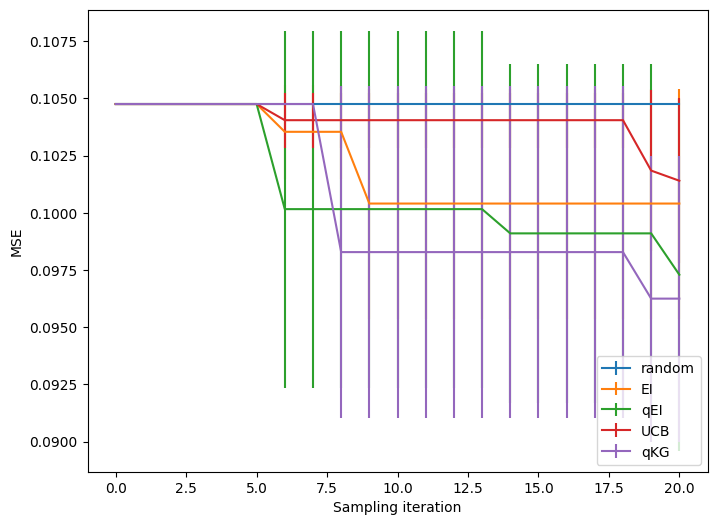

In [42]:
# plot the results
def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)
    # return y.std(axis=0)

iters = np.arange(N_ROUND + 1) * BATCH_SIZE
y_ei = np.asarray(best_observed_ei_all)*-1
y_qei = np.asarray(best_observed_qei_all)*-1
y_ucb = np.asarray(best_observed_ucb_all)*-1
y_qkg = np.asarray(best_observed_qkg_all)*-1
y_rnd = np.asarray(best_random_all)*-1

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_rnd.mean(axis=0), yerr=ci(y_rnd), label="random", linewidth=1.5)
ax.errorbar(iters, y_ei.mean(axis=0), yerr=ci(y_ei), label="EI", linewidth=1.5)
ax.errorbar(iters, y_qei.mean(axis=0), yerr=ci(y_qei), label="qEI", linewidth=1.5)
ax.errorbar(iters, y_ucb.mean(axis=0), yerr=ci(y_ucb), label="UCB", linewidth=1.5)
ax.errorbar(iters, y_qkg.mean(axis=0), yerr=ci(y_qkg), label="qKG", linewidth=1.5)
# ax.set_ylim(bottom=0.5)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
plt.xlabel("Sampling iteration")
plt.ylabel("MSE")
ax.legend(loc="lower right")


In [43]:
def extract_last_entry(x):
    tmp = []
    for i in range(4):
        tmp.append(x[i][-1])
    return tmp

In [47]:
rst_df = pd.DataFrame({
    "EI": [np.mean(extract_last_entry(best_observed_ei_all))*-1, np.std(extract_last_entry(best_observed_ei_all))],
    "qEI": [np.mean(extract_last_entry(best_observed_qei_all))*-1, np.std(extract_last_entry(best_observed_qei_all))],
    "UCB": [np.mean(extract_last_entry(best_observed_ucb_all))*-1, np.std(extract_last_entry(best_observed_ucb_all))],
    "qKG": [np.mean(extract_last_entry(best_observed_qkg_all))*-1, np.std(extract_last_entry(best_observed_qkg_all))],
    "random": [np.mean(extract_last_entry(best_random_all))*-1, np.std(extract_last_entry(best_random_all))],
}, index=["mean", "std"])
rst_df

,EI,qEI,UCB,qKG,random
mean,0.100403,0.097293,0.101399,0.096248,0.104751
std,0.005127,0.007848,0.003668,0.006374,0.000000


# References

1. A combined architecture of <b>multivariate LSTM</b> with Mahalanobis and Z-Score transformations for oil price forecasting
2. A detailed look at crude oil price volatility prediction using <b>macroeconomic variables</b>
3. Crude oil price prediction using deep reinforcement learning

# Versioning

In [ ]:
print(f'numpy: {np.__version__}\npandas: {pd.__version__}\nseaborn: {sns.__version__}\n\
yfinance: {yf.__version__}\ntalib: {talib.__version__}\ntensorflow: {tf.__version__}')
